## Problem Statement
Predict Loan Eligibility for Dream Housing Finance company
Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers.

Data Dictionary

Train file: CSV containing the customers for whom loan eligibility is known as 'Loan_Status'

Variable	--------------------------                                            Description

Loan_ID           --------------------             Unique Loan ID

Gender            --------------------	             Male/ Female

Married	          --------------------             Applicant married (Y/N)

Dependents        --------------------	         Number of dependents

Education         --------------------	         Applicant Education (Graduate/ Under Graduate)

Self_Employed     -------------------	     Self employed (Y/N)

ApplicantIncome   -----------------	     Applicant income

CoapplicantIncome -------------------	 Coapplicant income

LoanAmount        -----------------------	         Loan amount in thousands

Loan_Amount_Term  ---------------------	 Term of loan in months

Credit_History    ------------------	     credit history meets guidelines

Property_Area      -------------------	     Urban/ Semi Urban/ Rural

Loan_Status	(Target)--------------------   Loan approved (Y/N)

In [434]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


from scipy import sparse
from scipy.sparse import csr_matrix
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [435]:
train=pd.read_csv("train.csv")

In [436]:
train.shape

(614, 13)

In [127]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [128]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Note:In python, the missing values are stored as NaN

## Missing Values

Missing data, or missing values, occur when __no data__ / __no value__ is stored for certain observations within a variable. 

Incomplete data is an unavoidable problem in most data sources, and may have a significant impact on the conclusions that can be derived from the data. 

### Why is data missing?

The source of missing data can be very different. These are just a few examples:

- A value is missing because it was forgotten, lost or not stored properly
- For a certain observation, the value does not exist
- The value can't be known or identified

In many organisations, information is collected into a form by a person talking with a client on the phone, or alternatively, by customers filling forms online. Often, the person entering the data does not complete all the fields in the form. Many of the fields are not compulsory, which may lead to missing values.

The reasons for omitting the information can vary: perhaps the person does not want to disclose some information, for example income, or they do not know the answer, or the answer is not applicable for a certain circumstance, or on the contrary, the person in the organisation wants to spare the customer some time, and therefore omits asking questions they think are not so relevant.

There are other cases where the value for a certain variable does not exist. For example, in the variable 'total debt as percentage of total income' (very common in financial data), if the person has no income, then the total percentage of 0 does not exist, and therefore it will be a missing value.

It is important to understand **how the missing data are introduced in the dataset**, that is, the **mechanisms** by which missing information is introduced in a dataset. Depending on the mechanism, we may choose to process the missing values differently. In addition, by knowing the source of missing data, we may choose to take action to control that source and decrease the amount of missing information looking forward during data collection.


### Missing Data Mechanisms

There are 3 mechanisms that lead to missing data, 2 of them involve missing data randomly or almost-randomly, and the third one involves a systematic loss of data.

#### Missing Completely at Random, MCAR:

A variable is missing completely at random (MCAR) if the probability of being missing is the same for all the observations. 
When data is MCAR, there is absolutely no relationship between the data missing and any other values, observed or missing, within the dataset. In other words, those missing data points are a random subset of the data. There is nothing systematic going on that makes some data more likely to be missing than other. If values for observations are missing completely at random, then disregarding those cases would not bias the inferences made.


#### Missing at Random, MAR: 

MAR occurs when there is a relationship between the propensity of missing values and the observed data. In other words, the probability of an observation being missing depends on available information (i.e., other variables in the dataset). For example, if men are more likely to disclose their weight than women, weight is MAR. The weight information will be missing at random for those men and women who do not disclose their weight, but as men are more prone to disclose it, there will be more missing values for women than for men.

In a situation like the above, if we decide to proceed with the variable with missing values (in this case weight), we might benefit from including gender to control the bias in weight for the missing observations.


#### Missing Not at Random, MNAR: 

Missing data is not at random (MNAR) when there is a mechanism or a reason why missing values are introduced in the dataset. For example, MNAR would occur if people failed to fill in a depression survey because of their level of depression. Here, the missing of data is related to the outcome, depression. Similarly, when a financial company asks for bank and identity documents from customers in order to prevent identity fraud, typically, fraudsters impersonating someone else will not upload documents, because they don't have them, because they are fraudsters. Therefore, there is a systematic relationship between the missing documents and the target we want to predict: fraud.

Understanding the mechanism by which data is missing is important to decide which methods to use to impute the missing values.

====================================================================================================

In [129]:
# we can quantify the total number of missing values using
# the isnull method plus the sum method on the dataframe
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

There are 13 missing values for Gender,3 for Married and so on.....

In [130]:
# alternatively, we can use the mean method after isnull
# to visualise the percentage of
# missing values for each variable
train.isnull().mean()

Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

## Cardinality

The values of a categorical variable are selected from a group of categories, also called labels. For example, in the variable _gender_ the categories or labels are male and female, whereas in the variable _city_ the labels can be London, Manchester, Brighton and so on.

Different categorical variables contain different number of labels or categories. The variable gender contains only 2 labels, but a variable like city or postcode, can contain a huge number of different labels.

The number of different labels within a categorical variable is known as cardinality. A high number of labels within a variable is known as __high cardinality__.


### Are multiple labels in a categorical variable a problem?

High cardinality may pose the following problems: 

- Variables with too many labels tend to dominate over those with only a few labels, particularly in **Tree based** algorithms.

- A big number of labels within a variable may introduce noise with little, if any, information, therefore making machine learning models prone to over-fit.

- Some of the labels may only be present in the training data set, but not in the test set, therefore machine learning algorithms may over-fit to the training set.

- Contrarily, some labels may appear only in the test set, therefore leaving the machine learning algorithms unable to perform a calculation over the new (unseen) observation.


In particular, **tree methods can be biased towards variables with lots of labels** (variables with high cardinality). Thus, their performance may be affected by high cardinality.
.


In [131]:
# let's inspect the cardinality, this is the number
# of different labels, for the different categorical variables

print('Number of categories in the variable Gender: {}'.format(
    len(train.Gender.unique())))

print('Number of categories in the variable Married: {}'.format(
    len(train.Married.unique())))

print('Number of categories in the variable Dependents: {}'.format(
    len(train.Dependents.unique())))

print('Number of categories in the variable Education: {}'.format(
    len(train.Education.unique())))

print('Number of categories in the variable Self_Employed: {}'.format(
    len(train.Self_Employed.unique())))
print('Number of categories in the variable ApplicantIncome: {}'.format(
    len(train.ApplicantIncome.unique())))

print('Number of categories in the variable CoapplicantIncome: {}'.format(
    len(train.CoapplicantIncome.unique())))

print('Number of categories in the variable LoanAmount: {}'.format(
    len(train.LoanAmount.unique())))

print('Number of categories in the variable Loan_Amount_Term: {}'.format(
    len(train.Loan_Amount_Term.unique())))

print('Number of categories in the variable Credit_History: {}'.format(
    len(train.Credit_History.unique())))
print('Number of categories in the variable Property_Area: {}'.format(
    len(train.Property_Area.unique())))

print('Total number of Applications: {}'.format(len(train)))

Number of categories in the variable Gender: 3
Number of categories in the variable Married: 3
Number of categories in the variable Dependents: 5
Number of categories in the variable Education: 2
Number of categories in the variable Self_Employed: 3
Number of categories in the variable ApplicantIncome: 505
Number of categories in the variable CoapplicantIncome: 287
Number of categories in the variable LoanAmount: 204
Number of categories in the variable Loan_Amount_Term: 11
Number of categories in the variable Credit_History: 3
Number of categories in the variable Property_Area: 3
Total number of Applications: 614


# Rare Labels

## Labels that occur rarely

Categorical variables are those which values are selected from a group of categories, also called labels. Different labels appear in  the dataset with different frequencies. Some categories appear a lot in the dataset, whereas some other categories appear only in a few number of observations.

For example, in a dataset with information about loan applicants where one of the variables is "city" where the applicant lives, cities like 'New York' may appear a lot in the data because New York has a huge population, whereas smaller towns like 'Leavenworth' will appear only on a few occasions (population < 2000 people), because the population there is very small. A borrower is more likely to live in New York, because far more people live in New York.

In fact, categorical variables often contain a few dominant labels that account for the majority of the observations and a large number of labels that appear only seldom.


### Are Rare Labels in a categorical variable a problem?

Rare values can add a lot of information or none at all. For example, consider a stockholder meeting where each person can vote in proportion to their number of shares. One of the shareholders owns 50% of the stock, and the other 999 shareholders own the remaining 50%. The outcome of the vote is largely influenced by the shareholder who holds the majority of the stock. The remaining shareholders may have an impact collectively, but they have almost no impact individually.  

The same occurs in real life datasets. The label that is over-represented in the dataset tends to dominate the outcome, and those that are under-represented may have no impact individually, but could have an impact if considered collectively.

More specifically,

- Rare values in categorical variables tend to cause over-fitting, particularly in tree based methods.

- A big number of infrequent labels adds noise, with little information, therefore causing over-fitting.

- Rare labels may be present in training set, but not in test set, therefore causing over-fitting to the train set.

- Rare labels may appear in the test set, and not in the train set. Thus, the machine learning model will not know how to evaluate it. 


**Note** Sometimes rare values, are indeed important. For example, if we are building a model to predict fraudulent loan applications, which are by nature rare, then a rare value in a certain variable, may be indeed very predictive. This rare value could be telling us that the observation is most likely a fraudulent application, and therefore we would choose not to ignore it.

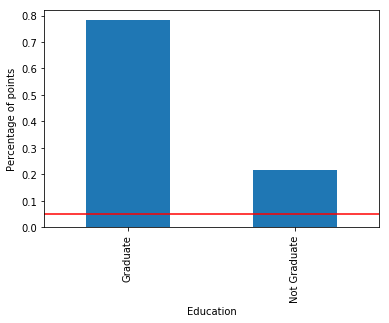

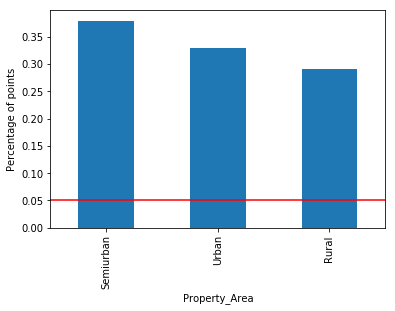

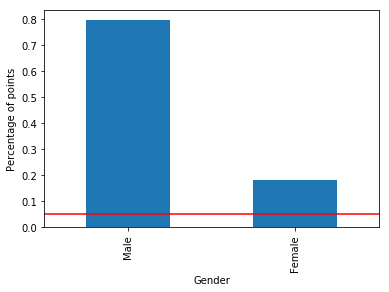

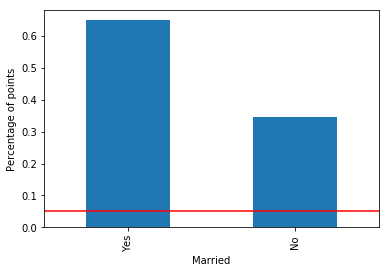

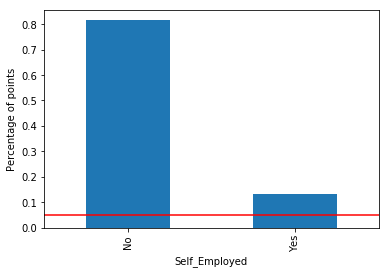

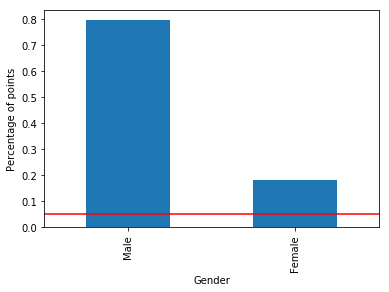

In [132]:
# let's plot how frequently each label
# appears in the dataset

cat_cols = ['Education', 'Property_Area','Gender','Married','Self_Employed','Gender']


total = len(train)

# for each categorical variable
for col in cat_cols:


    temp_df = pd.Series(train[col].value_counts() / total)

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of points')
    plt.show()

For each of the categorical variables, There were no one less than 5% so there are no Rare Values and could not cause any over-fitting.

### Rare labels: grouping under a new label

One common way of working with rare or infrequent values, is to group them under an umbrella category called 'Rare' or 'Other'. In this way, we are able to understand the "collective" effect of the infrequent labels on the target.

### Rare labels lead to uneven distribution of categories in train and test sets

Similarly to highly cardinal variables, rare or infrequent labels often land only on the training set, or only on the testing set. If present only in the training set, they may lead to over-fitting. If present only on the testing set, the machine learning algorithm will not know how to handle them, as they have not seen the rare labels during training. Let's explore this further.

In [133]:
test=pd.read_csv("test.csv")

In [134]:
test.shape

(367, 12)

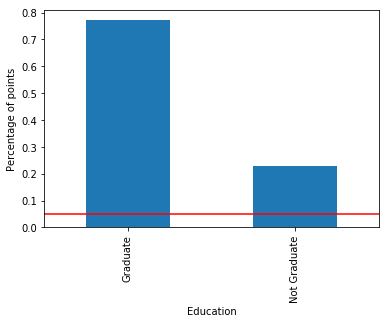

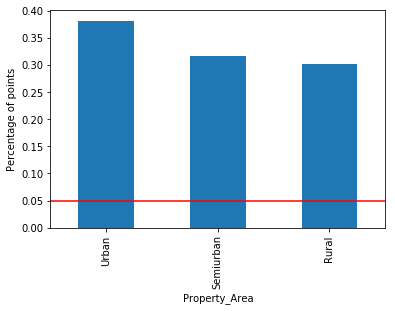

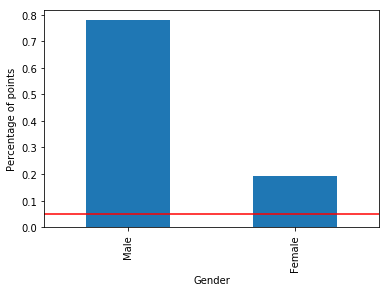

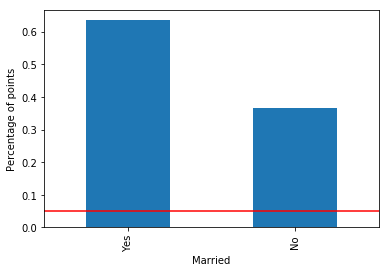

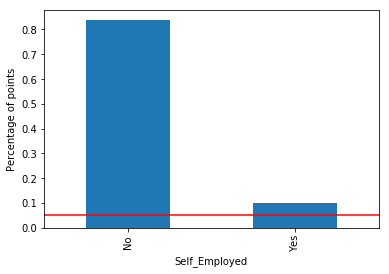

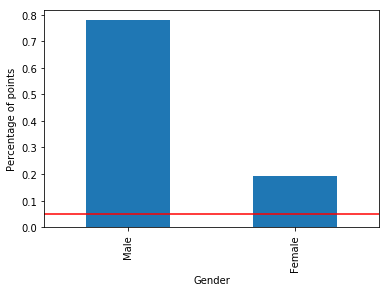

In [135]:
# let's plot how frequently each label
# appears in the dataset

cat_cols = ['Education', 'Property_Area','Gender','Married','Self_Employed','Gender']


total = len(test)

# for each categorical variable
for col in cat_cols:


    temp_df = pd.Series(test[col].value_counts() / total)

    # make plot with the above percentages
    fig = temp_df.sort_values(ascending=False).plot.bar()
    fig.set_xlabel(col)

    # add a line at 5 % to flag the threshold for rare categories
    fig.axhline(y=0.05, color='red')
    fig.set_ylabel('Percentage of points')
    plt.show()

Seeems to be all labels present in training data are present in test data

## Missing Data Imputution

## 1)Complete Case Analysis


Complete-case analysis (CCA), also called "list-wise deletion" of cases, consists in **discarding** observations where values in **any** of the variables are missing. Complete Case Analysis means literally analysing only those observations for which there is information in **all** of the variables in the dataset. 

### Which variables can I impute with CCA?

CCA can be applied to both categorical and numerical variables.


### Assumptions

CCA works well when the data are missing completely at random (MCAR). In fact, we should use CCA if we have reasons to believe that data is missing at random, and not otherwise. When data is MCAR, excluding observations with missing information is in essence the same as randomly excluding some observations from the dataset. Therefore the dataset after CCA is a fair representation of the original dataset. 


### Advantages

- Easy to implement
- No data manipulation required
- Preserves variable distribution (if data is MCAR, then the distribution of the variables of the reduced dataset should match the distribution in the original dataset)

### Disadvantages

- It can exclude a large fraction of the original dataset (if missing data is abundant)
- Excluded observations could be informative for the analysis (if data is not missing at random)
- CCA will create a biased dataset if the complete cases differ from the original data (e.g., when missing information is in fact MAR or NMAR and not missing at random).
- When using our models in production, the model will not know how to handle missing data

### When to use CCA

- Data is missing completely at random
- No more than 5% of the total dataset contains missing data

In practice, CCA may be an acceptable method when the amount of missing information is small. Unfortunately, there is no rule of thumb to determine how much missing data is small or negligible. However, as general guidance, if the total amount of missing data is ~5% of the original dataset or less, CCA is a viable option.

In many real life datasets, the amount of missing data is never small, and therefore CCA is typically never an option.

### CCA and models in production

When using CCA, we remove all observations that contain missing information. However, the data that we want to score with our model, may indeed contain missing information. This will pose a problem when using our model in live systems, or as we call it, when putting or models into production: when an observation contains missing data, the model will not be able to handle it. 

In order to avoid this problem, when putting models into production we need to do 1 of 2 things: either we do not score observations with missing data, or we replace the missing values by another number.


In [136]:
# let's find out the percentage of observations missing per variable

# using the isnull() and mean() methods from pandas
data_na_per = train.isnull().mean()

# transform the array into a dataframe
data_na_per = pd.DataFrame(data_na_per.reset_index())

# add column names to the dataframe
data_na_per.columns = ['variable', 'na_percentage']

# order the dataframe according to percentage of na per variable
data_na_per.sort_values(by='na_percentage', ascending=False, inplace=True)

# show
data_na_per

,variable,na_percentage
10,Credit_History,0.081433
5,Self_Employed,0.052117
8,LoanAmount,0.035831
3,Dependents,0.024430
9,Loan_Amount_Term,0.022801
1,Gender,0.021173
2,Married,0.004886
0,Loan_ID,0.000000
4,Education,0.000000
6,ApplicantIncome,0.000000


We can use CCA here as the missing data is not too much in the first 8 varaibles but let us stick to 5%

In [137]:
# capture variables with less than 5% nan

vars_cca = [var for var in train.columns if train[var].isnull().mean() > 0.0 ]
vars_cca

['Gender',
 'Married',
 'Dependents',
 'Self_Employed',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [138]:
delete=['Credit_History','Self_Employed']
final_vars=[]
for i in vars_cca:
    if i not in delete:
        final_vars.append(i)

In [139]:
final_vars

['Gender', 'Married', 'Dependents', 'LoanAmount', 'Loan_Amount_Term']

In [140]:
# calculate percentage of observations with complete
# cases: i.e., with values for all the variables

# the method dropna(), discards the observations that contain
# na in any of the rows / columns

len(train[final_vars].dropna()) / len(train)

0.9006514657980456

In [141]:
# create the complete case dataset
# in other words, remove observations with na in any variable

data_cca = train[final_vars].dropna()
train.shape, data_cca.shape

((614, 13), (553, 5))

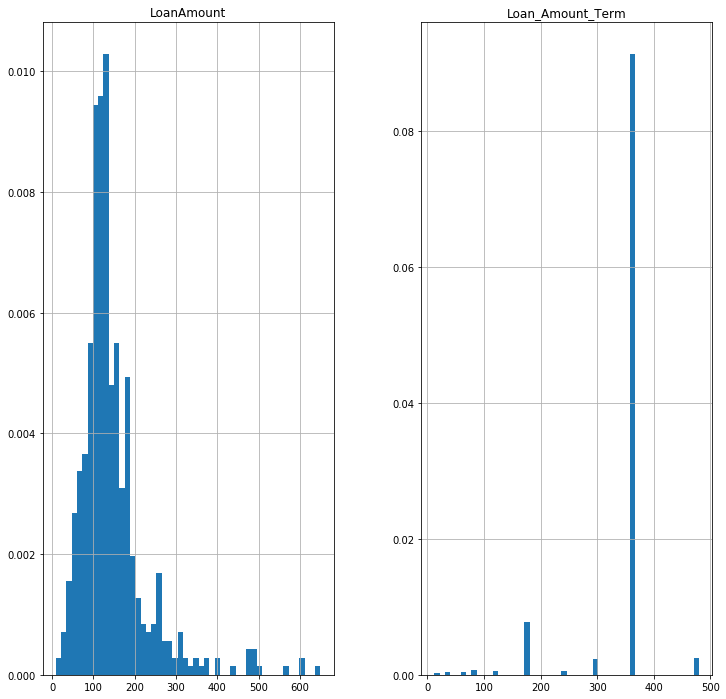

In [142]:
# plot the histograms for all numerival variables in the complete
# case dataset

data_cca.hist(bins=50, density=True, figsize=(12, 12))
plt.show()

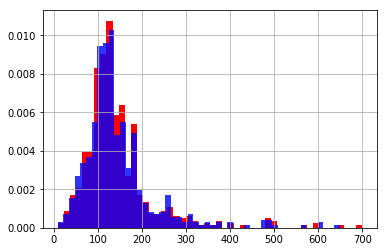

In [143]:
## let's check the distribution of a few variables before and after 
# cca: histogram

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
train['LoanAmount'].hist(bins=50, ax=ax, density=True, color='red')

# data after cca, the argument alpha makes the color transparent, so we can
# see the overlay of the 2 distributions
data_cca['LoanAmount'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

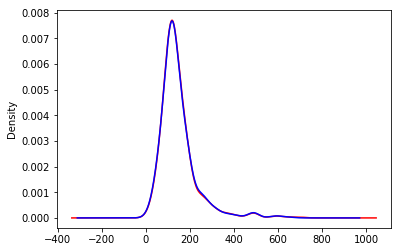

In [144]:
## let's check the distribution of a few variables before and after 
# cca: density plot

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
train['LoanAmount'].plot.density(color='red')

# data after cca
data_cca['LoanAmount'].plot.density(color='blue')

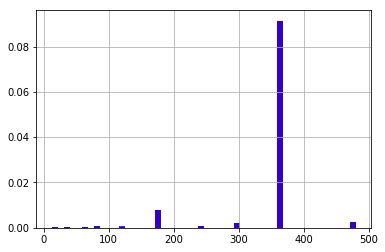

In [145]:
## let's check the distribution of a few variables before and after 
# cca: histogram

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
train['Loan_Amount_Term'].hist(bins=50, ax=ax, density=True, color='red')

# data after cca, the argument alpha makes the color transparent, so we can
# see the overlay of the 2 distributions
data_cca['Loan_Amount_Term'].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.8)

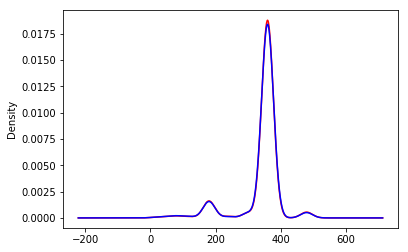

In [146]:
## let's check the distribution of a few variables before and after 
# cca: density plot

fig = plt.figure()
ax = fig.add_subplot(111)

# original data
train['Loan_Amount_Term'].plot.density(color='red')

# data after cca
data_cca['Loan_Amount_Term'].plot.density(color='blue')

As we can see from the above plots, the distribution of the selected numerical variables in the original and complete case dataset is very similar, which is what we expect from CCA if data is missing at random and only for a small proportion of the observations

In [147]:
# the following function captures the percentage of observations
# for each category in the original and complete case dataset
# and puts them together in a new dataframe


def categorical_distribution(df, df_cca, variable):
    tmp = pd.concat(
        [
            # percentage of observations per category, original data
            df[variable].value_counts() / len(df),

            # percentage of observations per category, cca data
            df_cca[variable].value_counts() / len(df_cca)
        ],
        axis=1)

    # add column names
    tmp.columns = ['original', 'cca']

    return tmp

In [148]:
# run the function in a categorical variable
categorical_distribution(train, data_cca, 'Gender')

,original,cca
Male,0.796417,0.811935
Female,0.182410,0.188065


In [149]:
# run the function in a categorical variable
categorical_distribution(train, data_cca, 'Married')

,original,cca
Yes,0.648208,0.649186
No,0.346906,0.350814


In [150]:
# run the function in a categorical variable
categorical_distribution(train, data_cca, 'Dependents')

,original,cca
0,0.561889,0.571429
1,0.166124,0.173599
2,0.164495,0.173599
3+,0.083062,0.081374


As we can see from the output of the cells above, the distribution in each of the categories, is very similar in the original and complete case dataset, which again, is what is expected if the data is missing completely at random, and the percentage of missing data is small.

## 2)Mean / Median imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Mean / median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).

**Note the following**:

- If a variable is normally distributed, the mean, median and mode, are approximately the same. Therefore, replacing missing values by the mean and the median are equivalent. Replacing missing data by the mode is not common practice for  numerical variables.
- If the variable is skewed, the mean is biased by the values at the far end of the distribution. Therefore, the median is a better representation of the majority of the values in the variable.
- For discrete variables casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, we can replace NA with the median instead. The median will inevitably be an integer / discrete value as well.


### Which variables can I impute with Mean / Median Imputation?

The mean and median can only be calculated on numerical variables, therefore these methods are suitable for continuous and discrete numerical variables only.


### Assumptions

- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mean / median)

If data is missing completely at random, then it is fair to assume that the missing values, are most likely very close to the value of the mean or the median of the distribution, as these represent the most frequent / average observation.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)

### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset

When replacing NA with the mean or median, the variance of the variable will be distorted if the number of NA is big respect to the total number of observations, leading to underestimation of the variance.

In addition, estimates of covariance and correlations with other variables in the dataset may also be affected. Mean / median imputation may alter intrinsic correlations since the mean / median value that now replaces the missing data will not necessarily preserve the relation with the remaining variables.

Finally, concentrating all missing values at the mean / median value, may lead to observations that are common occurrences in the distribution, to be picked up as outliers.


### When to use mean / median imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

Although in theory, the above conditions should be met to minimise the impact of this imputation technique, in practice, mean / median imputation is very commonly used, even in those cases when data is not MCAR and there are a lot of missing values. The reason behind this, is the simplicity of the technique.


Typically, mean / median imputation is done together with adding a binary "missing indicator" variable to capture those observations where the data was missing (see lecture "Missing Indicator"), thus covering 2 angles: if the data was missing completely at random, this would be captured by the mean /median imputation, and if it wasn't this would be captured by the additional "missing indicator" variable. Both methods are extremely straight forward to implement, and therefore are a top choice in data science competitions.

### Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the mean / median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

In [162]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [157]:
train.isnull().mean()

Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [163]:
# let's make a function to fill missing values with the mean or median:
# the variable takes the dataframe, the variable, and the value of the
# mean or median
# and returns the variable with the filled na


def impute_na(df, variable, mean_median):

    return df[variable].fillna(mean_median)

In [166]:
median = train.LoanAmount.median()
mean = train.LoanAmount.mean()

In [168]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
train['LoanAmount_median'] = impute_na(train, 'LoanAmount', median)

# now replace with the mean
train['LoanAmount_mean'] = impute_na(train, 'LoanAmount', mean)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
train['LoanAmount_mean'] = np.round(train['LoanAmount_mean'], 1)

train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_median,LoanAmount_mean
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,128.0,146.4
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,128.0,128.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,66.0,66.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,120.0,120.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,141.0,141.0


In [172]:
# we can see a little bit of change in the variance after mean / median imputation 
#because of the % of data missing is less


print('Original variable variance: ', train['LoanAmount'].var())
print('Variance after median imputation: ', train['LoanAmount_median'].var())
print('Variance after mean imputation: ', train['LoanAmount_mean'].var())

Original variable variance:  7325.190241002424
Variance after median imputation:  7074.026706909471
Variance after mean imputation:  7062.295979722725


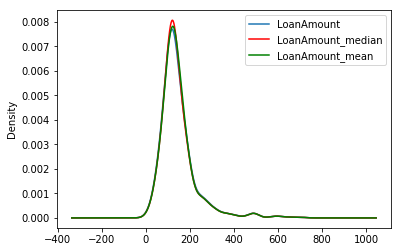

In [174]:
# we can see that the distribution has not changed much after imputution 


fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['LoanAmount'].plot(kind='kde', ax=ax)

# variable imputed with the median
train['LoanAmount_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
train['LoanAmount_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

As mentioned above, the mean / median imputation may distorts the original distribution of the variable Age.

Linear models assume that the variables are normally distributed. Mean / median imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

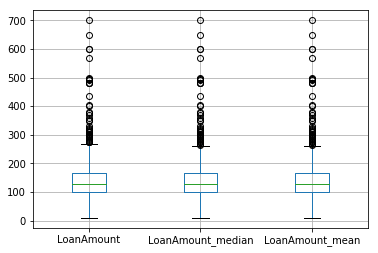

In [175]:
# mean / median imputation may lead 
# to observations that are normal, to look like outliers

# or in other words, mean / median imputation may lead to an increase
# in the apparent number of  outliers

# Let's find out using a boxplot
train[['LoanAmount', 'LoanAmount_median', 'LoanAmount_mean']].boxplot()

From the boxplot above, we can see that after the imputation outliers remained same there is no increase

**Note**: If we are after true outliers, we need to keep this behaviour in mind, to make sure that we are neither masking nor creating artificial outliers with our imputation technique.

In [176]:
train.cov()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_median,LoanAmount_mean
ApplicantIncome,3.732039e+07,-2.084490e+06,301192.495450,-18207.365609,-33.671724,290397.998060,290382.986775
CoapplicantIncome,-2.084490e+06,8.562930e+06,47909.140428,-11503.765339,-1.854510,46570.025909,46189.977134
LoanAmount,3.011925e+05,4.790914e+04,7325.190241,222.894173,-0.255510,7325.190241,7325.190241
Loan_Amount_Term,-1.820737e+04,-1.150377e+04,222.894173,4240.667780,0.034019,217.392321,214.812020
Credit_History,-3.367172e+01,-1.854510e+00,-0.255510,0.034019,0.133136,-0.225152,-0.247578
LoanAmount_median,2.903980e+05,4.657003e+04,7325.190241,217.392321,-0.225152,7074.026707,7062.303723
LoanAmount_mean,2.903830e+05,4.618998e+04,7325.190241,214.812020,-0.247578,7062.303723,7062.295980


mean / median imputation may affect the relationship with other varaibles in the dataset There is not much different in this case

For Varaible Loan_Amount_Term

In [190]:
median = train.Loan_Amount_Term .median()
mean = train.Loan_Amount_Term .mean()

In [191]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
train['Loan_Amount_Term_median'] = impute_na(train, 'Loan_Amount_Term', median)

# now replace with the mean
train['Loan_Amount_Term_mean'] = impute_na(train, 'Loan_Amount_Term', mean)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
train['Loan_Amount_Term_mean'] = np.round(train['Loan_Amount_Term_mean'], 1)

train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_median,LoanAmount_mean,Loan_Amount_Term_median,Loan_Amount_Term_mean
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,128.0,146.4,360.0,360.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,128.0,128.0,360.0,360.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,66.0,66.0,360.0,360.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,120.0,120.0,360.0,360.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,141.0,141.0,360.0,360.0


In [192]:
# we can see a little bit of change in the variance after mean / median imputation 
#because of the % of data missing is less


print('Original variable variance: ', train['Loan_Amount_Term'].var())
print('Variance after median imputation: ', train['Loan_Amount_Term_median'].var())
print('Variance after mean imputation: ', train['Loan_Amount_Term_mean'].var())

Original variable variance:  4240.667779632721
Variance after median imputation:  4151.048243539801
Variance after mean imputation:  4143.817292006525


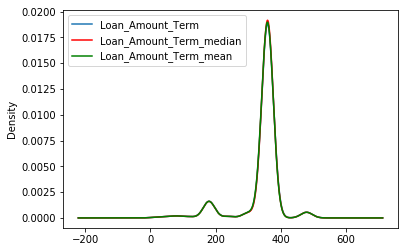

In [193]:
# we can see that the distribution has not changed much after imputution 


fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['Loan_Amount_Term'].plot(kind='kde', ax=ax)

# variable imputed with the median
train['Loan_Amount_Term_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
train['Loan_Amount_Term_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

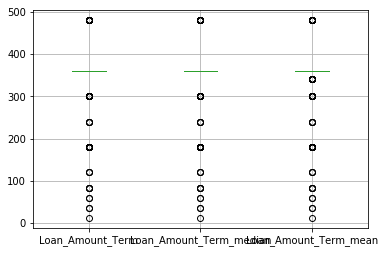

In [194]:
# mean / median imputation may lead 
# to observations that are normal, to look like outliers

# or in other words, mean / median imputation may lead to an increase
# in the apparent number of  outliers

# Let's find out using a boxplot
train[['Loan_Amount_Term', 'Loan_Amount_Term_median', 'Loan_Amount_Term_mean']].boxplot()

In [195]:
train.cov()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_median,LoanAmount_mean,Loan_Amount_Term_median,Loan_Amount_Term_mean
ApplicantIncome,3.732039e+07,-2.084490e+06,301192.495450,-18207.365609,-33.671724,290397.998060,290382.986775,-18314.518335,-17791.536705
CoapplicantIncome,-2.084490e+06,8.562930e+06,47909.140428,-11503.765339,-1.854510,46570.025909,46189.977134,-11195.741238,-11241.036604
LoanAmount,3.011925e+05,4.790914e+04,7325.190241,222.894173,-0.255510,7325.190241,7325.190241,204.841816,217.718068
Loan_Amount_Term,-1.820737e+04,-1.150377e+04,222.894173,4240.667780,0.034019,217.392321,214.812020,4240.667780,4240.667780
Credit_History,-3.367172e+01,-1.854510e+00,-0.255510,0.034019,0.133136,-0.225152,-0.247578,-0.086996,0.034201
LoanAmount_median,2.903980e+05,4.657003e+04,7325.190241,217.392321,-0.225152,7074.026707,7062.303723,200.284477,212.427406
LoanAmount_mean,2.903830e+05,4.618998e+04,7325.190241,214.812020,-0.247578,7062.303723,7062.295980,197.492080,209.906036
Loan_Amount_Term_median,-1.831452e+04,-1.119574e+04,204.841816,4240.667780,-0.086996,200.284477,197.492080,4151.048244,4143.817292
Loan_Amount_Term_mean,-1.779154e+04,-1.124104e+04,217.718068,4240.667780,0.034201,212.427406,209.906036,4143.817292,4143.817292


For Varaible Credit_History

In [196]:
median = train.Credit_History.median()
mean = train.Credit_History.mean()

In [197]:
# create a new variable with the missing values replaced
# using the function we created above

# first replace with the median
train['Credit_History_median'] = impute_na(train, 'Credit_History', median)

# now replace with the mean
train['Credit_History_mean'] = impute_na(train, 'Credit_History', mean)

# the mean contains many decimals, so I round to 1
# using the round function from numpy
train['Loan_Amount_Term_mean'] = np.round(train['Credit_History_mean'], 1)

train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_median,LoanAmount_mean,Loan_Amount_Term_median,Loan_Amount_Term_mean,Credit_History_median,Credit_History_mean
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,128.0,146.4,360.0,1.0,1.0,1.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,128.0,128.0,360.0,1.0,1.0,1.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,66.0,66.0,360.0,1.0,1.0,1.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,120.0,120.0,360.0,1.0,1.0,1.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,141.0,141.0,360.0,1.0,1.0,1.0


In [198]:
# we can see a little bit of change in the variance after mean / median imputation 
#because of the % of data missing is less


print('Original variable variance: ', train['Credit_History'].var())
print('Variance after median imputation: ', train['Credit_History_median'].var())
print('Variance after mean imputation: ', train['Credit_History_mean'].var())

Original variable variance:  0.1331361878487838
Variance after median imputation:  0.12414249353050996
Variance after mean imputation:  0.12227679242881777


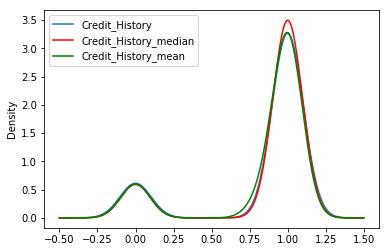

In [199]:
# we can see that the distribution has not changed much after imputution 


fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['Credit_History'].plot(kind='kde', ax=ax)

# variable imputed with the median
train['Credit_History_median'].plot(kind='kde', ax=ax, color='red')

# variable imputed with the mean
train['Credit_History_mean'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## 3) Arbitrary value imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can be used to train machine learning models.

Arbitrary value imputation consists of replacing all occurrences of missing values (NA) within a variable by an arbitrary value. Typically used arbitrary values are 0, 999, -999 (or other combinations of 9s) or -1 (if the distribution is positive).


### Which variables can I impute with an arbitrary value?

Both categorical and numerical variables can be imputed by arbitrary values. 

For categorical variables, this is the equivalent of replacing all instances of NA by an additional label, which is very common practice, so I will treat it separately in a future notebook.

### Assumptions

- Data is not missing at random.

If this is the case, we want to flag the missing values with a different (arbitrary) value, instead of replacing those occurrences with the mean or the median, which represent the most common value.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingness" if there is one


### Limitations

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- If the arbitrary value is at the end of the distribution it may mask or create outliers
- Need to be careful not to chose an arbitrary value too similar to the mean or median (or any other common value of the variable distribution)


### When to use arbitrary value imputation

Replacing the NA by arbitrary values should be used when there are reasons to believe that the NA are not missing at random. In situations like this, we would not like to replace with the median or the mean, and therefore make the NA look like the majority of our observations. Instead, we want to flag the fact that the observation is missing.

This approach is used widely both in organisations and in Kaggle competitions. It consists of replacing the NA by an arbitrary value. Any of your creation, but ideally different from the median/mean/mode, and not within the normal values of the variable.

The problem consists in deciding which arbitrary value to choose.

### Imputation important

Imputation should be done over the training set, and then propagated to the test set. For arbitrary value imputation this is not so important, because we chose the value arbitrarily, however it is good to adhere to this practice and select the arbitrary value by looking only at the distribution of the variables in the train set

In [204]:
train.isnull().mean()

Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [205]:
# let's make a function to fill missing values with an arbitrary value:
# the variable takes the dataframe, the variable, and the value to replace na

# and returns the variable with the filled na


def impute_na(df, variable, value):

    return df[variable].fillna(value)

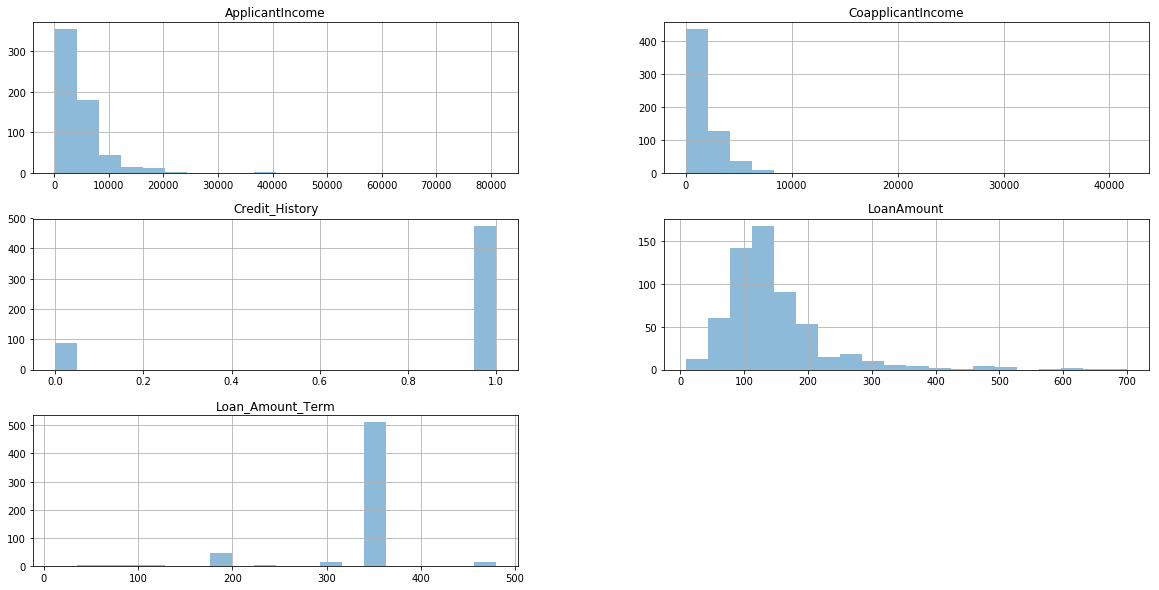

In [208]:
train.hist(bins=20,alpha=0.5, figsize=(20, 10))
plt.show()

In [212]:
# Lets replace NA by 2 different arbitrary values
# one at the far right end of the distribution ==> 999 (As Loanamount can take value upto 700)
# and alternatively by -1, taking LoanAmount that Age takes only positive values

# first replace with 99
train['LoanAmount_999'] = impute_na(train, 'LoanAmount', 999)

# now replace with -1
train['LoanAmount_minus1'] = impute_na(train, 'LoanAmount', -1)

train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_999,LoanAmount_minus1
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,999.0,-1.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,128.0,128.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,66.0,66.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,120.0,120.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,141.0,141.0


In [214]:
# we can see a change in the variance after arbitrary value imputation

print('Original variable variance: ', train['LoanAmount'].var())
print('Variance after 999 imputation: ', train['LoanAmount_999'].var())
print('Variance after -1 imputation: ', train['LoanAmount_minus1'].var())

Original variable variance:  7325.190241002424
Variance after 999 imputation:  32215.528649085278
Variance after -1 imputation:  7814.234219489769


In fact, the effect on the variance will also be driven by the magnitude of the arbitrary value selected for the imputation, compare 999 with -1.

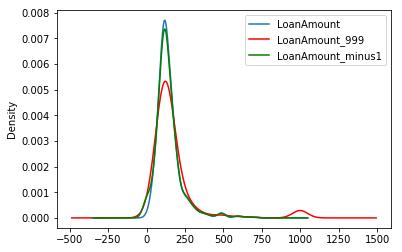

In [215]:
# we can see that the distribution has changed 
# with now more values accumulating towards the arbitrary values

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['LoanAmount'].plot(kind='kde', ax=ax)

# variable imputed with 99
train['LoanAmount_999'].plot(kind='kde', ax=ax, color='red')

# variable imputed with -1
train['LoanAmount_minus1'].plot(kind='kde', ax=ax, color='green')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Arbitrary value imputation distorts the original distribution of the variable. The transformed variable shows more values around arbitrary values.

**Is this important?**

It depends on the machine learning model we want to build. Linear models assume that the variables are normally distributed. Arbitrary value imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn may affect the linear model performance.

On the other hand, this technique works quite well with tree based algorithms.

In [218]:
# Arbitrary value imputation may affect the relationship 
# with the other variables in the dataset, let's have a look

train.cov()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_999,LoanAmount_minus1
ApplicantIncome,3.732039e+07,-2.084490e+06,301192.495450,-18207.365609,-33.671724,289687.409499,290503.240224
CoapplicantIncome,-2.084490e+06,8.562930e+06,47909.140428,-11503.765339,-1.854510,28579.673573,49234.498298
LoanAmount,3.011925e+05,4.790914e+04,7325.190241,222.894173,-0.255510,7325.190241,7325.190241
Loan_Amount_Term,-1.820737e+04,-1.150377e+04,222.894173,4240.667780,0.034019,95.248748,235.482471
Credit_History,-3.367172e+01,-1.854510e+00,-0.255510,0.034019,0.133136,-1.286705,-0.067930
LoanAmount_999,2.896874e+05,2.857967e+04,7325.190241,95.248748,-1.286705,32215.528649,2713.310158
LoanAmount_minus1,2.905032e+05,4.923450e+04,7325.190241,235.482471,-0.067930,2713.310158,7814.234219


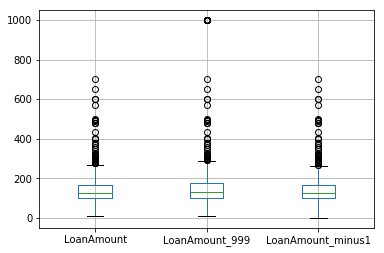

In [221]:
#Arbitrary value imputation may affect the perception of outliers


# Let's find out using a boxplot
train[['LoanAmount', 'LoanAmount_999', 'LoanAmount_minus1']].boxplot()

## 4) End of distribution imputation

Previous notebook we replaced missing data by an arbitrary value. However, determining the value of the arbitrary value can be laborious and it is usually a manual job. We can automate this process by automatically selecting arbitrary values at the end of the variable distributions.

#### How do we select the value at the end?

- If the variable is normally distributed, we can use the mean plus or minus 3 times the standard deviation
- If the variable is skewed, we can use the IQR proximity rule

- We can also select the min / max value and multiply it by a certain amount of times, like 2 or 3.


### Which variables can I impute with an arbitrary value?

This method is suitable for numerical variables.

### Assumptions

- MNAR - values are not missing at random

If the value is not missing at random, we don't want to replace it for the mean / median and therefore make that observation look like the majority of our observations. Instead, we want to flag that observation as different, and therefore we assign a value that is at the tail of the distribution, where observations are rarely represented in the population.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingess" if there is one

### Disadvantages

- Distortion of the original variable distribution
- Distortion of the original variance
- Distortion of the covariance with the remaining variables of the dataset
- This technique may mask true outliers in the distribution

In [223]:
# far end of the distribution:

# Because LoanAmount looks approximately Gaussian, I use the
# mean and std to calculate the replacement value

train.LoanAmount.mean() + 3 * train.LoanAmount.std()

403.1741378692785

In [226]:
# replace NA with the value calculated above

train['LoanAmount_imputed'] = impute_na(train, 'LoanAmount',
                                   train.LoanAmount.mean() + 3 *train.LoanAmount.std())

train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_imputed
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,403.174138
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,128.000000
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,66.000000
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,120.000000
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,141.000000


In [228]:
# we can see a less change in the variance after end of tail imputation
# this is expected, because the percentage of missing data is quite low

print('Original variable variance: ', train['LoanAmount'].var())
print('Variance after End Distribution imputation: ', train['LoanAmount_imputed'].var())

Original variable variance:  7325.190241002424
Variance after End Distribution imputation:  9343.567393772437


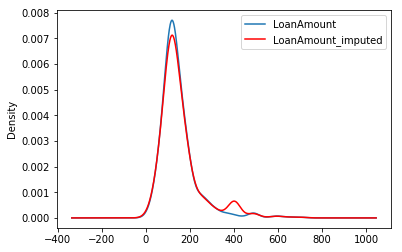

In [229]:
# we can see that the distribution has changed 
# with now more values accumulating towards the tail

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
train['LoanAmount'].plot(kind='kde', ax=ax)

# imputed variable
train['LoanAmount_imputed'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [231]:
train.cov()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,LoanAmount_imputed
ApplicantIncome,3.732039e+07,-2.084490e+06,301192.495450,-18207.365609,-33.671724,290173.502544
CoapplicantIncome,-2.084490e+06,8.562930e+06,47909.140428,-11503.765339,-1.854510,40886.352322
LoanAmount,3.011925e+05,4.790914e+04,7325.190241,222.894173,-0.255510,7325.190241
Loan_Amount_Term,-1.820737e+04,-1.150377e+04,222.894173,4240.667780,0.034019,178.803627
Credit_History,-3.367172e+01,-1.854510e+00,-0.255510,0.034019,0.133136,-0.560527
LoanAmount_imputed,2.901735e+05,4.088635e+04,7325.190241,178.803627,-0.560527,9343.567394


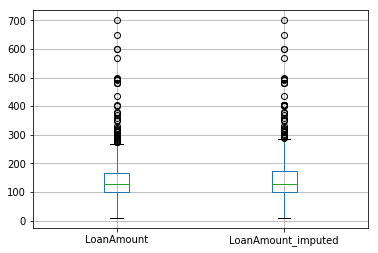

In [233]:
train[['LoanAmount', 'LoanAmount_imputed']].boxplot()

## 5)Frequent category imputation | Mode imputation

Mode imputation consists of replacing all occurrences of missing values (NA) within a variable by the mode, which in other words refers to the **most frequent value** or **most frequent category**.


### Which variables can I impute with most frequent / mode Imputation?

Although the mode, or most frequent value can be calculated for both numerical and categorical variables, in practice, we only use this technique on categorical variables. The reason is that for numerical variables, the mean or the median tend to better represent the average value of the population.


### Assumptions

- Data is missing completely at random (MCAR)
- The missing observations, most likely look like the majority of the observations in the variable (aka, the mode)

The rationale is that the value that should have been seen for the missing observation is most likely the most frequent value or category of the variable.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)


### Limitations

- Distortion the relation of the most frequent label with other variables within the dataset
- May lead to an over-representation of the most frequent label if there is a big number of NA


### When to use mode / most frequent category imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data

In [239]:
train.dtypes

Loan_ID                object
Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
LoanAmount_imputed    float64
dtype: object

In [235]:
train.isnull().mean()

Loan_ID               0.000000
Gender                0.021173
Married               0.004886
Dependents            0.024430
Education             0.000000
Self_Employed         0.052117
ApplicantIncome       0.000000
CoapplicantIncome     0.000000
LoanAmount            0.035831
Loan_Amount_Term      0.022801
Credit_History        0.081433
Property_Area         0.000000
Loan_Status           0.000000
LoanAmount_imputed    0.000000
dtype: float64

Text(0, 0.5, 'Number of Loans')

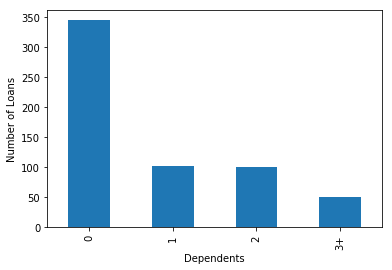

In [268]:
# let's inspect the number of observations per category in Dependents

# value_counts() counts the amount of houses that show each of the labels
# in the variable indicated below

train['Dependents'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Dependents')
plt.ylabel('Number of Loans')

In [269]:
# Let's find the most frequent category for Dependents

train['Dependents'].mode()

0    0
dtype: object

In [271]:
# I use the fillna() method from pandas

# with the argument inplace=True, I indicate to pandas
# that I want the values replaced in the same dataset

train['Dependents'].fillna('0', inplace=True)

In [272]:
# check that NA have been filled
train['Dependents'].isnull().sum()

0

Text(0, 0.5, 'Number of loans')

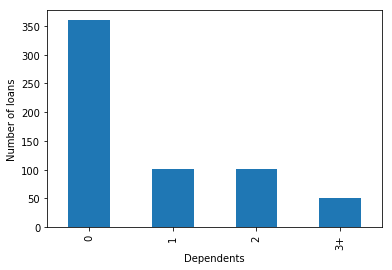

In [273]:
# evaluate effect on distribution of categories

train['Dependents'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Dependents')
plt.ylabel('Number of loans')

From the above plot, we see that now there are a few more houses with the label '0', which are those that before contained NA, 

when the percentage of missing values is so high (~50%) we are better off creating a new category to enclose the observations with NA.

Text(0, 0.5, 'Number of Loans')

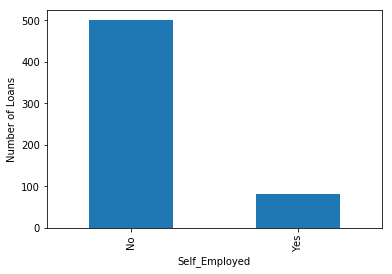

In [299]:
# let's inspect the number of observations per category in Married

# value_counts() counts the amount of houses that show each of the labels
# in the variable indicated below
    
train['Self_Employed'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Self_Employed')
plt.ylabel('Number of Loans')

Text(0, 0.5, 'Number of Loans')

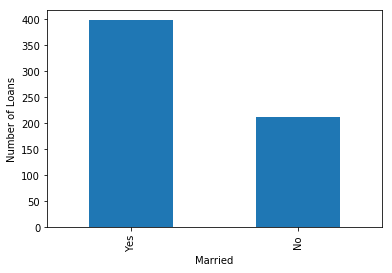

In [300]:
# let's inspect the number of observations per category in Married

# value_counts() counts the amount of houses that show each of the labels
# in the variable indicated below
    
train['Married'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Married')
plt.ylabel('Number of Loans')

Text(0, 0.5, 'Number of Loans')

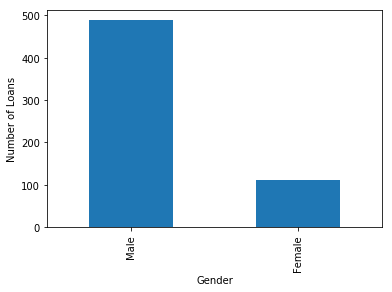

In [301]:
# let's inspect the number of observations per category in Gender

# value_counts() counts the amount of houses that show each of the labels
# in the variable indicated below
    
train['Gender'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Gender')
plt.ylabel('Number of Loans')

In [302]:
# IF we see above plots majority label will be the mode so we can replace NA with that label for aother fields

print(train['Self_Employed'].mode())
print(train['Gender'].mode())
print(train['Married'].mode())

0    No
dtype: object
0    Male
dtype: object
0    Yes
dtype: object


In [303]:
train['Self_Employed'].fillna('No', inplace=True)
train['Gender'].fillna('Male', inplace=True)
train['Married'].fillna('Yes', inplace=True)

In [305]:
# check that NA have been filled
print(train['Self_Employed'].isnull().sum())
print(train['Gender'].isnull().sum())
print(train['Married'].isnull().sum())

0
0
0


## 6)Arbitrary value imputation for categorical variables

This is the most widely used method of missing data imputation for categorical variables. This method consists in treating missing data as an additional label or category of the variable. All the missing observations are grouped in the newly created label 'Missing'.

This is in essence, the equivalent of replacing by an arbitrary value for numerical variables.

The beauty of this technique resides on the fact that it does not assume anything about the fact that the data is missing. It is very well suited when the number of missing data is high.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Can be integrated in production (during model deployment)
- Captures the importance of "missingness" if there is one
- No assumption made on the data


### Limitations

- If the number of NA is small, creating an additional category may cause trees to over-fit

For categorical variables this is the method of choice, as it treats missing values as a separate category, without making any assumption on the variable or the reasons why data could be missing.

In [308]:
train['Self_Employed'].fillna('Missing', inplace=True)
train['Gender'].fillna('Missing', inplace=True)
train['Married'].fillna('Missing', inplace=True)
train['Dependents'].fillna('Missing', inplace=True)

Text(0, 0.5, 'Number of Loans')

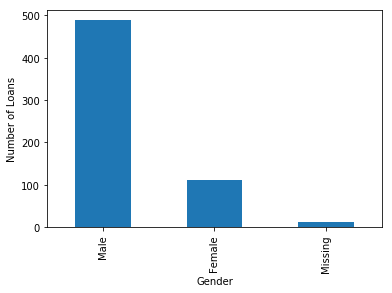

In [309]:
train['Gender'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Gender')
plt.ylabel('Number of Loans')

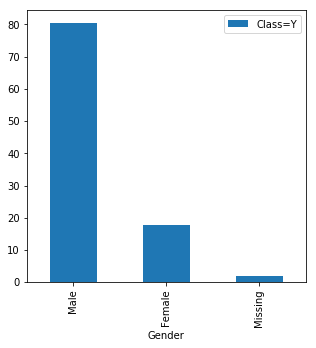

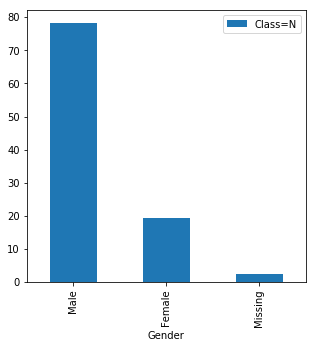

In [329]:
for i in ['Y','N']:
    classes = train.loc[train['Loan_Status'] == i]
    
    #Counting each Dependents count that had occured for the particluar class
    count_Gender = classes.Gender.value_counts().reset_index()
    #Giving column names as 'Gender','Count'
    count_Gender.columns = ['Gender', 'Count']
    #Getting the total count of Gender's
    total = count_Gender.Count.sum()

    #Getting the percentage count of each Gender
    count_Gender['Percentage'] = (count_Gender.Count/total)*100
    #Plotting Dependents having only greater than 2 occurences
    count_Gender.loc[count_Gender['Count'] > 2].plot(x='Gender', y='Percentage', kind='bar', figsize=(5, 5),label="Class=%s"%(i,))

Text(0, 0.5, 'Number of Loans')

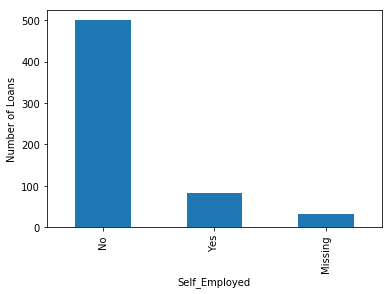

In [310]:
train['Self_Employed'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Self_Employed')
plt.ylabel('Number of Loans')

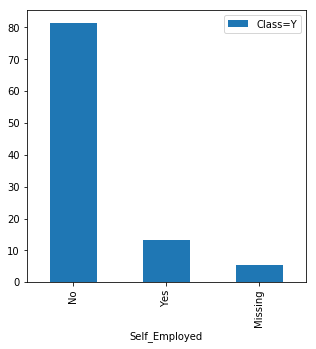

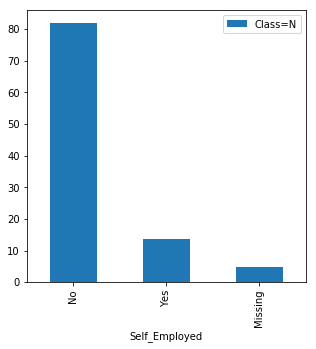

In [330]:
for i in ['Y','N']:
    classes = train.loc[train['Loan_Status'] == i]
    
    #Counting each Self_Employed count that had occured for the particluar class
    count_Self_Employed = classes.Self_Employed.value_counts().reset_index()
    #Giving column names as 'Self_Employed','Count'
    count_Self_Employed.columns = ['Self_Employed', 'Count']
    #Getting the total count of Self_Employed's
    total = count_Self_Employed.Count.sum()

    #Getting the percentage count of each Gender
    count_Self_Employed['Percentage'] = (count_Self_Employed.Count/total)*100
    #Plotting Self_Employed having only greater than 2 occurences
    count_Self_Employed.loc[count_Self_Employed['Count'] > 2].plot(x='Self_Employed', y='Percentage', kind='bar', figsize=(5, 5),label="Class=%s"%(i,))

Text(0, 0.5, 'Number of Loans')

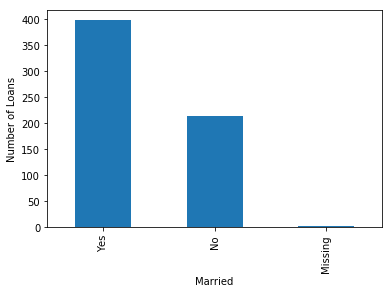

In [311]:
train['Married'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Married')
plt.ylabel('Number of Loans')

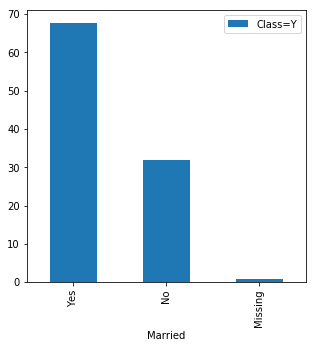

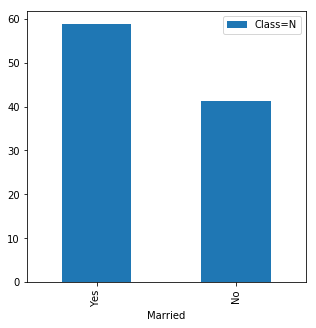

In [331]:
for i in ['Y','N']:
    classes = train.loc[train['Loan_Status'] == i]
    
    #Counting each Married count that had occured for the particluar class
    count_Married = classes.Married.value_counts().reset_index()
    #Giving column names as 'Married','Count'
    count_Married.columns = ['Married', 'Count']
    #Getting the total count of Married's
    total = count_Married.Count.sum()

    #Getting the percentage count of each Married
    count_Married['Percentage'] = (count_Married.Count/total)*100
    #Plotting Self_Employed having only greater than 2 occurences
    count_Married.loc[count_Married['Count'] > 2].plot(x='Married', y='Percentage', kind='bar', figsize=(5, 5),label="Class=%s"%(i,))

## NOTE:
Interesting observation here where Married column has NA value has Loan_Status is Yes 'Y'

Text(0, 0.5, 'Number of Loans')

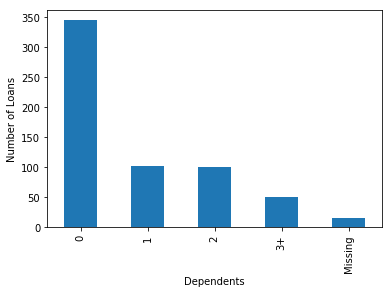

In [312]:
train['Dependents'].value_counts().sort_values(ascending=False).plot.bar()
plt.xlabel('Dependents')
plt.ylabel('Number of Loans')

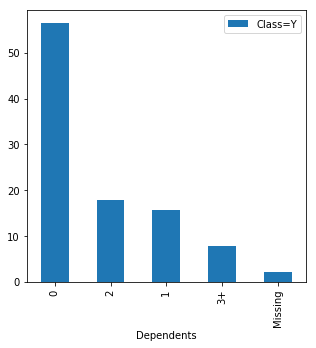

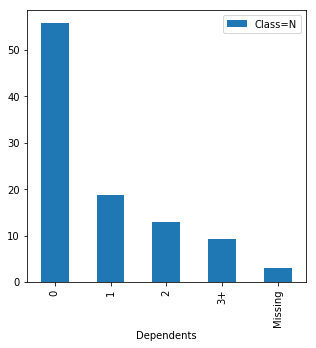

In [327]:
for i in ['Y','N']:
    classes = train.loc[train['Loan_Status'] == i]
    
    #Counting each Dependents count that had occured for the particluar class
    count_Dependents = classes.Dependents.value_counts().reset_index()
    #Giving column names as 'Dependents','Count'
    count_Dependents.columns = ['Dependents', 'Count']
    #Getting the total count of Dependents's
    total = count_Dependents.Count.sum()

    #Getting the percentage count of each Dependents
    count_Dependents['Percentage'] = (count_Dependents.Count/total)*100
    #Plotting Dependents having only greater than 2 occurences
    count_Dependents.loc[count_Dependents['Count'] > 2].plot(x='Dependents', y='Percentage', kind='bar', figsize=(5, 5),label="Class=%s"%(i,))

## 7) Random sample imputation

Random sampling imputation is in principle similar to mean / median / mode imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In random sample imputation one takes as many random observations as missing values are present in the variable.

By random sampling observations of the variable for those instances where data is available, we guarantee that the mean and standard deviation of the variable are preserved.

By random sampling observations of the present categories, for categorical variables, we guarantee that the frequency of the different categories / labels within the variable is preserved.


### Which variables can I impute by Random Sample Imputation?

Random Sample Imputation can be applied to both numerical and categorical variables.


### Assumptions

Random sample imputation assumes that the data are missing completely at random (MCAR). If this is the case, it makes sense to substitute the missing values by values extracted from the original variable distribution. 

From a probabilistic point of view, values that are more frequent, like the mean or the median or the most frequent category, for categorical variables, will be selected more often -because there are more of them to select from-, but other less frequent values will be selected as well. Thus, the variance and distribution of the variable are preserved. 

The idea is to replace the population of missing values with a population of values with the same distribution of the original variable.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Preserves the variance of the variable

### Limitations

- Randomness
- The relationship of imputed variables with other variables may be affected if there are a lot of NA
- Memory heavy for deployment, as we need to store the original training set to extract values from and replace the NA in coming observations.


### When to use Random Sample Imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data
- Well suited for linear models as it does not distort the distribution, regardless of the % of NA

If used in combination with a Missing Indicator, as we will see in the next lecture, then this method can be used when data is not missing at random as well, or when there are many missing observations.


#### Randomness

Randomness may not seem much of a concern when replacing missing values for data competitions, where the whole batch of missing values is replaced once and then the dataset is scored and that is the end of the problem. However, in business scenarios the situation is very different. 

Imagine for example a car manufacturer is trying to predict how long a certain car will be in the garage before it passes all the security tests. Today, they receive a car with missing data in some of the variables, they run the machine learning model to predict how long this car will stay in the garage, the model replaces missing values by a random sample of the variable and then produces an estimate of time. Tomorrow, when they run the same model on the same car, the model will randomly assign values to the missing data, that may or may not be the same as the ones it selected today, therefore, the final estimation of time in the garage, may or may not be the same as the one obtained the day before.

In addition, imagine the car manufacturer evaluates 2 different cars that have exactly the same values for all of the variables, and missing values in exactly the same subset of variables. They run the machine learning model for each car, and because the missing data is randomly filled with values, the 2 cars, that are exactly the same, may end up with different estimates of time in the garage.

This may sound completely trivial and unimportant, however, businesses must follow a variety of regulations, and some of them require the same treatment to be provided to the same situation. So if instead of cars, these were people applying for a loan, or people seeking for disease treatment, the machine learning model would end up providing different solutions to candidates that are otherwise in the same conditions. And this is not fair or acceptable. This behaviour needs to be avoided.

#### So, should we randomly replace NA or not?

It is still possible to replace missing data by random sample, but these randomness needs to be controlled, so that individuals in the same situation end up with the same scores and therefore with the same solutions offered. How can we ensure this? by appropriately setting seeds during the random extraction of values.

Finally, another potential limitation of random sampling, similarly to replacing with the mean and median, is that estimates of covariance and correlations with other variables in the dataset may also be washed off by the randomness, particularly if there are a lot of missing observations.


### Final note

Replacement of missing values by random sample, although similar in concept to replacement by the median or mean, is not as widely used in the data science community as the mean / median imputation, presumably because of the element of randomness, or because the code implementation is not so straightforward.

However, it is a valid approach, with clear advantages over mean / median imputation as it preserves the distribution of the variable. And if you are mindful of the element of randomness and account for it somehow, this may as well be your method of choice, particularly for linear models.

In [334]:
train.isnull().mean()

Loan_ID              0.000000
Gender               0.021173
Married              0.004886
Dependents           0.024430
Education            0.000000
Self_Employed        0.052117
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           0.035831
Loan_Amount_Term     0.022801
Credit_History       0.081433
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [340]:
# let's impute Age by random sampling both in
# train and test sets

# create the new variable where NA will be imputed:
# make a copy from the original variable, with NA
train['LoanAmount_imputed'] = train['LoanAmount'].copy()

# extract the random sample to fill the na:
# remember we do this always from the train set, and we use
# these to fill both train and test

random_sample_train = train['LoanAmount'].dropna().sample(
    train['LoanAmount'].isnull().sum(), random_state=0)

# 1) dropna() removes the NA from the original variable, this
# means that I will randomly extract existing values and not NAs

# 2) sample() is the method that will do the random sampling

# 3) X_train['Age'].isnull().sum() is the number of random values to extract
# I want to extract as many values as NAs are present in the original variable

# 4) random_state sets the seed for reproducibility, so that I extract 
# always the same random values, every time I run this notebook

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = train[train['LoanAmount'].isnull()].index

# replace the NA in the newly created variable
train.loc[train['LoanAmount'].isnull(), 'LoanAmount_imputed'] = random_sample_train


In [342]:
# check that NA were imputed
train['LoanAmount_imputed'].isnull().sum()

0

In [343]:
train.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_imputed
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,255.0
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,128.0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,66.0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,120.0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,141.0


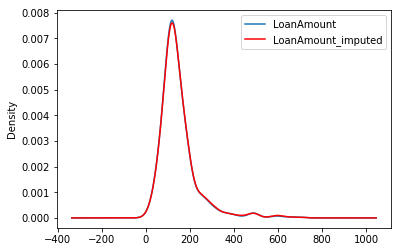

In [345]:
# we can see that the distribution of the variable after
# random sample imputation is almost exactly the same as the original

fig = plt.figure()
ax = fig.add_subplot(111)

train['LoanAmount'].plot(kind='kde', ax=ax)
train['LoanAmount_imputed'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

We can see that replacing missing values with a random sample from the training set preserves the original distribution of the variable.random sample imputation preserves the distribution, even if the %of missing value are high. So this imputation technique is quite handy, if we are building linear models and we don't want to distort normal distributions.

## 8) Adding a variable to capture NA

In previous notebooks we learnt how to replace missing values by the mean, median or by extracting a random value. In other words we learnt about mean / median and random sample imputation. These methods assume that the data are missing completely at random (MCAR).

There are other methods that can be used when values are not missing at random, for example arbitrary value imputation or end of distribution imputation. However, these imputation techniques will affect the variable distribution dramatically, and are therefore not suitable for linear models.

**So what can we do if data are not MCAR and we want to use linear models?**

If data are not missing at random, it is a good idea to replace missing observations by the mean / median / mode AND  **flag** those missing observations as well with a **Missing Indicator**. A Missing Indicator is an additional binary variable, which indicates whether the data was missing for an observation (1) or not (0).


### For which variables can I add a missing indicator?

We can add a missing indicator to both numerical and categorical variables. 

#### Note

Adding a missing indicator is never used alone. On the contrary, it is always used together with another imputation technique, which can be mean / median imputation for numerical variables, or frequent category imputation for categorical variables. We can also use random sample imputation together with adding a missing indicator for both categorical and numerical variables.

Commonly used together:

- Mean / median imputation + missing indicator (Numerical variables)
- Frequent category imputation + missing indicator (Categorical variables)
- Random sample Imputation + missing indicator (Numerical and categorical)

### Assumptions

- Data is not missing at random
- Missing data are predictive

### Advantages

- Easy to implement
- Captures the importance of missing data if there is one

### Limitations

- Expands the feature space
- Original variable still needs to be imputed to remove the NaN

Adding a missing indicator will increase 1 variable per variable in the dataset with missing values. So if the dataset contains 10 features, and all of them have missing values, after adding a missing indicator we will have a dataset with 20 features: the original 10 features plus additional 10 binary features, which indicate for each of the original variables whether the value was missing or not. This may not be a problem in datasets with tens to a few hundreds variables, but if our original dataset contains thousands of variables, by creating an additional variable to indicate NA, we will end up with very big datasets. 

#### Important

In addition, data tends to be missing for the same observation across multiple variables, which often leads to many of the missing indicator variables to be actually similar or identical to each other.

### Final note

Typically, mean / median / mode imputation is done together with adding a variable to capture those observations where the data was missing, thus covering 2 angles: if the data was missing completely at random, this would be contemplated by the mean / median / mode imputation, and if it wasn't this would be captured by the missing indicator.


In [347]:
# add the missing indicator

# this is done very simply by using np.where from numpy
# and isnull from pandas:

train['LoanAmount_NA'] = np.where(train['LoanAmount'].isnull(), 1, 0)
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_NA
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0


In [349]:
# for example median imputation

median = train['LoanAmount'].median()

train['LoanAmount'] = train['LoanAmount'].fillna(median)

# check that there are no more missing values
train['LoanAmount'].isnull().mean()

0.0

In [350]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,LoanAmount_NA
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,Y,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,0
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,0
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,0


# Top coding, bottom coding and zero coding

## Outliers

An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980].

Statistics such as the mean and variance are very susceptible to outliers. In addition, **some Machine Learning models are indeed sensitive to outliers and their performance might be impaired by them**. Thus, it is common practice to engineer the features to minimise the impact of outliers on the performance of these algorithms.


### Nature of outliers

- Genuine extremely high or extremely low values
- Introduced due to mechanical error (wrong measurement)
- Introduced by replacing missing values (NA) by a value out of the distribution (as described in previous lectures)

In some cases, the presence of outliers is informative, and therefore they deserve further study.  

## How can we pre-process outliers?

- Mean/median imputation or random sampling
- Discrestisation
- Discard the outliers: process also called Trimming
- Top-coding, bottom-coding and zero-coding: also known as windsorization


### Mean/median imputation or random sampling

If we have reasons to believe that the outliers are due to mechanical error or problems during measurement. This means, if the outliers are in nature similar to missing data, then any of the methods discussed for missing data can be applied to replace outliers. Because the number of outliers is in nature small (otherwise they would not be outliers), it is reasonable to use the mean/median imputation to replace them.

### Discretisation

Discretisation is the transformation of continuous variables into discrete variables. It involves assigning the variable values into defined groups. For example, for the variable age, we could group the observations (people) into buckets / groups like: 0-20, 21-40, 41-60, > 61. This grouping of the variables in ranges is called discretisation. As you can see, any outlier (extremely high) value of age would be included in the > 61 group, therefore minimising its impact.

### Trimming

Trimming refers to the removal of the extreme values of a sample. In this procedure, the outliers are identified and those observations removed from the sample. On the down side, these values, may contain useful information for other variables included in the dataset. Thus, likely, we may choose not to remove these observations and handle outliers by top / bottom coding as described below.


## Top-coding, bottom-coding and zero-coding.

**Top-conding**, widely used in econometrics and statistics, means capping the maximum of a distribution at an arbitrarily set value. A top-coded variable is one for which data points whose values are above an upper bound are censored. This means in practical terms that all values above the upper band will be arbitrarily set to the upper band.

Top-coding is common practice in survey data, before it is released to the public. It is used to preserve the anonymity of respondents. For example, high earners may be easily identifiable by their earnings. Thus, by implementing top-coding, that outlier is capped at a certain maximum value and therefore looks like many other observations, it is not uniquely identifiable any more. Top-coding can be also applied to prevent possibly-erroneous outliers from being published.

Bottom-coding is analogous, but on the left side of the distribution. This is, all values below a certain threshold, are capped at that threshold. If the threshold is zero, then it is known as **zero-coding**, e.g. if amounts below zero are reported as zero. Good examples would be the variable "age", or the variable "earnings". It is not possible to have negative age or a negative salary, thus, it is reasonable to cap the lowest values at zero. Any observation with a value under zero must have been introduced by mistake.

Top-coding and bottom-coding are indeed used in practice to remove outliers of variables and therefore prevent model over-fitting.

#### Note

Top-coding may affect estimates of the standard errors of the variable, or change the variable distribution, by censoring those values at the far end of the tails.


### Identifying outliers

#### Extreme Value Analysis

The most basic form of outlier detection is Extreme Value Analysis of 1-dimensional data. The key for this method is to determine the statistical tails of the underlying distribution of the variable, and then finding the values that sit at the very end of the tails.

In the typical scenario, the distribution of the variable is Gaussian and thus outliers will lie outside the mean plus or minus 3 times the standard deviation of the variable.

If the variable is not normally distributed, a general approach is to calculate the quantiles, and then the interquantile range (IQR), as follows:

IQR = 75th quantile - 25th quantile

An outlier will sit outside the following upper and lower boundaries:

Upper boundary = 75th quantile + (IQR * 1.5)

Lower boundary = 25th quantile - (IQR * 1.5)

or for extreme cases:

Upper boundary = 75th quantile + (IQR * 3)

Lower boundary = 25th quantile - (IQR * 3)

=======================================================================


## Identify variable distribution

In Normally distributed variables, outliers are those values that lie beyond the mean plus or minus 3 times the standard deviation. If the variables are skewed however, we find outliers using the inter-quantile range. In order to decide which method to utilise to detect outliers, we first need to know the distribution of the variable.

We can use histograms and Q-Q plots to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable utilising the first quartile, the median, the third quartile and the whiskers.

Looking at a boxplot, you can easily identify:

- The median, indicated by the line within the box.
- The inter-quantile range (IQR), the box itself.
- The quantiles, 25th (Q1) is the lower and 75th (Q3) the upper end of the box.
- The wiskers, which extend to: 
  -- top whisker: Q3 + 1.5 x IQR
  -- bottom whisker: Q1 -1.5 x IQR

Any value sitting outside the whiskers is considered an outlier. Let's look at the examples below.

In [380]:
from statsmodels.graphics.gofplots import stats
import pylab
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

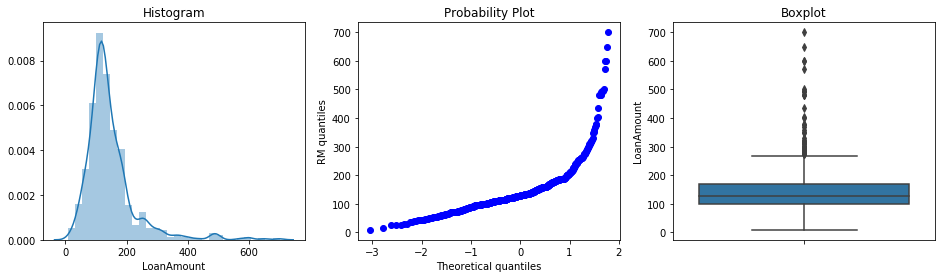

In [385]:
diagnostic_plots(train, 'LoanAmount')

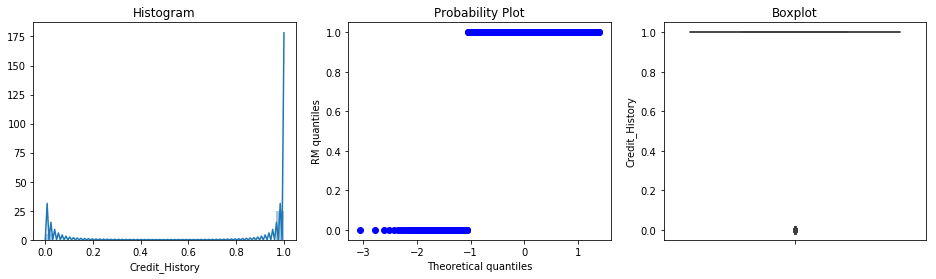

In [386]:
diagnostic_plots(train, 'Credit_History')

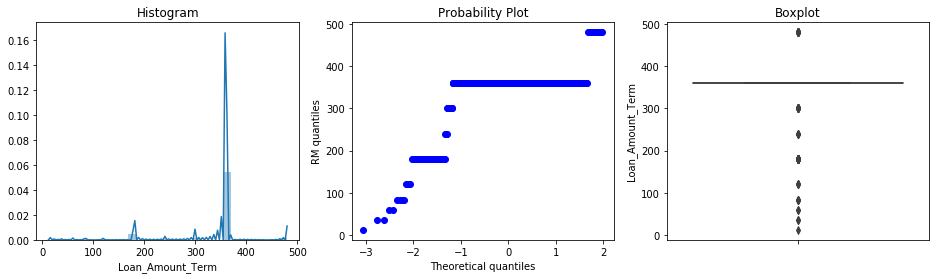

In [384]:
diagnostic_plots(train, 'Loan_Amount_Term')

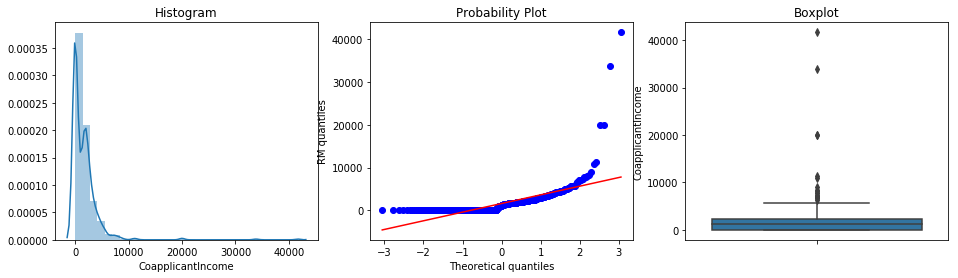

In [383]:
diagnostic_plots(train, 'CoapplicantIncome')

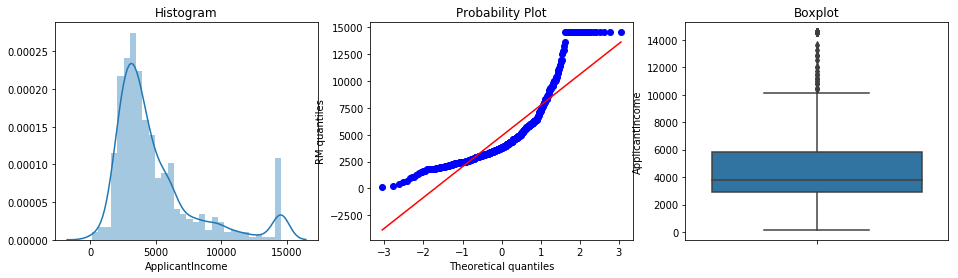

In [382]:
diagnostic_plots(train, 'ApplicantIncome')

In [359]:
train.skew(axis = 0, skipna = True) 

ApplicantIncome      6.539513
CoapplicantIncome    7.491531
LoanAmount           2.677552
Loan_Amount_Term    -2.362414
Credit_History      -1.882361
dtype: float64

Application income and CoapplicantIncome seems to be skewed and Loan amount is Normally distributed

Text(0, 0.5, 'Number of Loans')

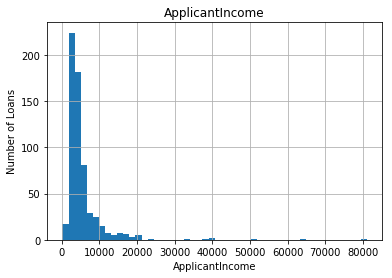

In [357]:
# First let's plot a histogram to get an idea of the distribution

fig = train.ApplicantIncome.hist(bins=50)
fig.set_title('ApplicantIncome')
fig.set_xlabel('ApplicantIncome')
fig.set_ylabel('Number of Loans')

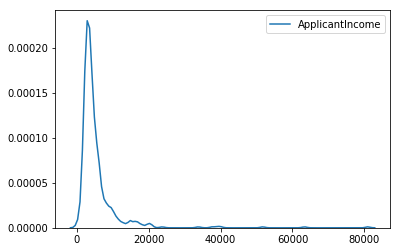

In [358]:
sns.kdeplot(train.ApplicantIncome)

Because the distribution of ApplicantIncome is skewed, we should estimate outliers using the quantile method instead of the Gaussian distribution.

Text(0, 0.5, 'Number of loans')

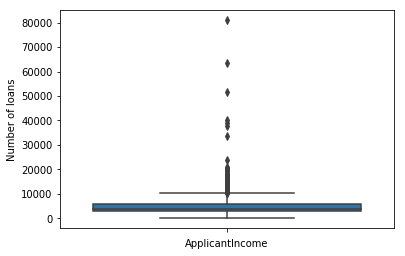

In [360]:
# visualising outliers using boxplots and whiskers, which provides the quantiles
# and inter-quantile range, with the outliers sitting outside the error bars.
# All the dots in the plot below are outliers according to the 1.5 IQR rule

fig = sns.boxplot(y='ApplicantIncome', data=train)
fig.set_xlabel('ApplicantIncome')
fig.set_ylabel('Number of loans')

The outliers, according to the above plot, lie all at the right side of the distribution. This is, some people have more income compared to others 

Therefore, in this variable, only extremely high values will affect the performance of our machine learning models, and we need to do therefore top-coding. Bottom coding in this case it is not necessary. At least not to improve the performance of the machine learning algorithms.

In [361]:
# let's look at the values of the quantiles so we can calculate the upper and lower boundaries for the outliers

train.ApplicantIncome.describe()

count      614.000000
mean      5403.459283
std       6109.041673
min        150.000000
25%       2877.500000
50%       3812.500000
75%       5795.000000
max      81000.000000
Name: ApplicantIncome, dtype: float64

In [362]:
# top coding: upper boundary for outliers according to interquantile proximity rule

IQR = train.ApplicantIncome.quantile(0.75) - train.ApplicantIncome.quantile(0.25)

Upper_fence = train.ApplicantIncome.quantile(0.75) + (IQR * 3)

Upper_fence

14547.5

In [365]:
# lets look at the actual number of people who has income above 14547.5
print('total loans: {}'.format(train.shape[0]))
print('people who has income above 14547.5: {}'.format(train[train.ApplicantIncome>14547.5].shape[0]))
print('percentage of outliers: {}'.format(train[train.ApplicantIncome>14547.5].shape[0]/np.float(train.shape[0])))

total loans: 614
people who has income above 14547.5: 32
percentage of outliers: 0.05211726384364821


In [367]:
# top-coding: capping the variable Fare at 14547.5
train.loc[train.ApplicantIncome>14547.5, 'ApplicantIncome'] = 14547.5
train.ApplicantIncome.max()

14547.5

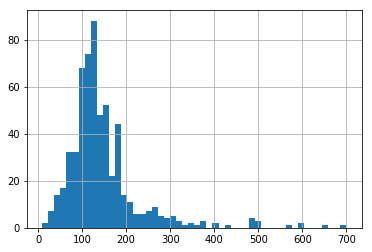

In [393]:
fig = train.LoanAmount.hist(bins=50)

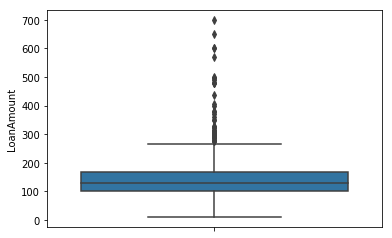

In [394]:
sns.boxplot(y='LoanAmount', data=train)

As expected, outliers sit on the right of the distribution. Therefore, we will perform top-coding.

In [401]:
train.LoanAmount.describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [412]:
# for normally distributed variables finding upper boundary

upper_boundary = train['LoanAmount'].mean() + 3 * train['LoanAmount'].std()
upper_boundary

403.1741378692785

In [409]:
# let's look at the percentage of high loaners within each extreme bucket

total_loaners = np.float(train.shape[0])
print('total loaners: {}'.format(train.LoanAmount.shape[0]/total_loaners))
print('loaners > 403: {}'.format(train[train.LoanAmount>403].shape[0]/total_loaners))

total loaners: 1.0
loaners > 403: 0.02280130293159609


In [410]:
# top-coding
train['loan_capped'] = np.where(train.LoanAmount>403, 403, train.LoanAmount)

train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,loan_capped
count,614.000000,614.000000,592.000000,600.00000,564.000000,592.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199,143.472973
std,6109.041673,2926.248369,85.587325,65.12041,0.364878,72.698198
min,150.000000,0.000000,9.000000,12.00000,0.000000,9.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000,100.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000,128.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000,168.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000,403.000000


(0, 500)

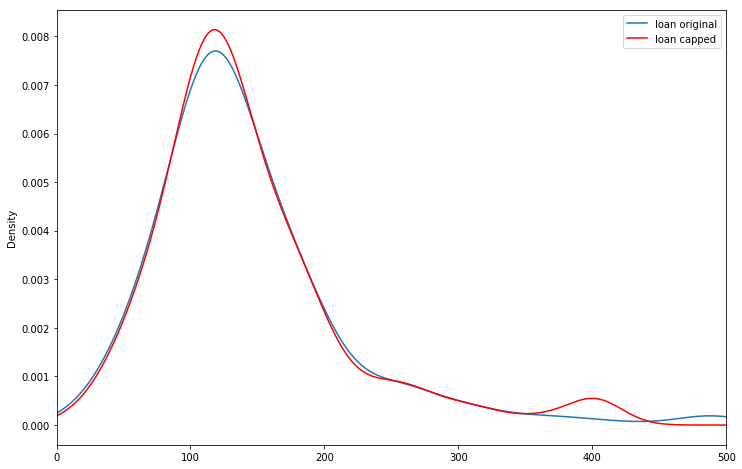

In [411]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
train.LoanAmount.plot(kind='kde', ax=ax)
train.loan_capped.plot(kind='kde', ax=ax, color = 'red')
lines, labels = ax.get_legend_handles_labels()
labels = ['loan original', 'loan capped']
ax.legend(lines, labels, loc='best')
ax.set_xlim(0,500)

We can observe the effect of top codding on the variable distribution. The maximum value corresponds now to the value we set as a cap. And we observe a peak in that value, that indicates that people that took loan more than the cap, are now grouped together under a capped maximum loan.

## Engineer labels of categorical variables


## One Hot Encoding

One hot encoding, consists of replacing the categorical variable by different boolean variables, which take value 0 or 1, to indicate whether or not a certain category / label of the variable was present for that observation.

Each one of the boolean variables are also known as **dummy variables** or binary variables.

For example, from the categorical variable "Gender", with labels 'female' and 'male', we can generate the boolean variable "female", which takes 1 if the person is female or 0 otherwise. We can also generate the variable male, which takes 1 if the person is "male" and 0 otherwise. 

See below:

In [415]:
data = pd.read_csv('train.csv', usecols=['Gender'])
data.head()

,Gender
0,Male
1,Male
2,Male
3,Male
4,Male


In [418]:
# for better visualisation
pd.concat([data, pd.get_dummies(data)], axis=1).tail()

,Gender,Gender_Female,Gender_Male
609,Female,1,0
610,Male,0,1
611,Male,0,1
612,Male,0,1
613,Female,1,0


As you may have noticed, we only need 1 of the 2 dummy variables to represent the original categorical variable Sex. Any of the 2 will suffice, and it doesn't matter which one we select, since they are equivalent.

Therefore, to encode a categorical variable with 2 labels, we need 1 dummy variable. 

To extend this concept, to encode  categorical variable with k labels, we need k-1 dummy variables.

How can we get this using pandas?

In [419]:
# obtaining k-1 labels
pd.get_dummies(data, drop_first=True).head()

,Gender_Male
0,1
1,1
2,1
3,1
4,1


In [420]:
# Let's now look at an example with more than 2 labels

data=pd.read_csv('train.csv', usecols=['Property_Area'])
data.head()

,Property_Area
0,Urban
1,Rural
2,Urban
3,Urban
4,Urban


In [422]:
# check the number of different labels
data.Property_Area.unique()

array(['Urban', 'Rural', 'Semiurban'], dtype=object)

In [423]:
# get whole set of dummy variables

pd.get_dummies(data).head()

,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [424]:
# get k-1 dummy variables

pd.get_dummies(data, drop_first=True).head()

,Property_Area_Semiurban,Property_Area_Urban
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [425]:
# we can also add an additional dummy variable to indicate whether there was missing data

pd.get_dummies(data, drop_first=True, dummy_na=True).head()

,Property_Area_Semiurban,Property_Area_Urban,Property_Area_nan
0,0,1,0
1,0,0,0
2,0,1,0
3,0,1,0
4,0,1,0


In [426]:
# by summing the number of 1s per boolean variable over the rows of the dataset, we get to know how
# many observations we have for each variable (i.e., each category)

pd.get_dummies(data, drop_first=True, dummy_na=True).sum(axis=0)

Property_Area_Semiurban    233
Property_Area_Urban        202
Property_Area_nan            0
dtype: int64

### Notes

Both pandas and sklearn will provide a whole set of dummy variables from a categorical variable. This is, instead of returning k-1 binary variables, they will return k, with the option in pandas of dropping the first binary variable and obtain k-1.

### When should you use k and when k-1?

When the original variable is binary, that is, when the original variable has only 2 labels, then you should create **one and only one** binary variable.

When the original variable has more than 2 labels, the following is important:

#### One hot encoding into k-1:
One hot encoding into k-1 binary variables takes into account that we can use 1 less dimension and still represent the whole information: if the observation is 0 in all the binary variables, then it must be 1 in the final (removed) binary variable. As an example, for the variable gender encoded into male, if the observation is 0, then it has to be female. We do not need the additional female variable to explain that. 

One hot encoding with k-1 binary variables should be used in linear regression, to keep the correct number of degrees of freedom (k-1). The linear regression has access to all of the features as it is being trained, and therefore examines altogether the whole set of dummy variables. This means that k-1 binary variables give the whole information about (represent completely) the original categorical variable to the linear regression.

And the same is true for all machine learning algorithms that look at ALL the features at the same time during training. For example, support vector machines and neural networks as well. And clustering algorithms.

#### One hot encoding into k dummy variables

However, tree based models select at each iteration only a group of features to make a decision. This is to separate the data at each node. Therefore, the last category, the one that was removed in the one hot encoding into k-1 variables, would only be taken into account by those splits or even trees, that use the entire set of binary variables at a time. And this would rarely happen, because each split usually uses 1-3 features to make a decision. So, tree based methods will never consider that additional label, the one that was dropped. Thus, if the categorical variables will be used in a tree based learning algorithm, it is good practice to encode it into k binary variables instead of k-1.

Finally, if you are planning to do feature selection, you will also need the entire set of binary variables (k) to let the machine learning model select which ones have the most predictive power.

Let's train a model on data with categorical variables re-encoded with One Hot Encoding.

## One Hot encoding:

### Advantages

- Straightforward to implement
- Makes no assumption
- Keeps all the information of the categorical variable

### Disadvantages

- Does not add any information that may make the variable more predictive
- If the variable has loads of categories, then OHE increases the feature space dramatically

## Ordinal numbering encoding

**Ordinal categorical variables**

Categorical variable which categories can be meaningfully ordered are called ordinal. For example:

- Student's grade in an exam (A, B, C or Fail).
- Days of the week can be ordinal with Monday = 1, and Sunday = 7.
- Educational level, with the categories: Elementary school,  High school, College graduate, PhD ranked from 1 to 4.

When the categorical variable is ordinal, the most straightforward approach is to replace the labels by some ordinal number.

### Advantages

- Keeps the semantical information of the variable (human readable content)
- Straightforward

### Disadvantage

- Does not add machine learning valuable information

## Count or frequency encoding

Another way to refer to variables that have a multitude of categories, is to call them variables with **high cardinality**.

We observed in the previous lecture, that if a categorical variable contains multiple labels, then by re-encoding them using one hot encoding, we will expand the feature space dramatically.

One approach that is heavily used in Kaggle competitions, is to replace each label of the categorical variable by the count, this is the amount of times each label appears in the dataset. Or the frequency, this is the percentage of observations within that category. The 2 are equivalent.

There is not any rationale behind this transformation, other than its simplicity.

### Advantages

- Simple
- Does not expand the feature space

### Disadvantages

-  If 2 labels appear the same amount of times in the dataset, that is, contain the same number of observations, they will be merged: may loose valuable information
- Adds somewhat arbitrary numbers, and therefore weights to the different labels, that may not be related to their predictive power

In [428]:
train.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [427]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [429]:
data = pd.read_csv('train.csv', usecols=['Gender','Married','Dependents','Education','Self_Employed','Property_Area'])
data.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,No,0,Graduate,No,Urban
1,Male,Yes,1,Graduate,No,Rural
2,Male,Yes,0,Graduate,Yes,Urban
3,Male,Yes,0,Not Graduate,No,Urban
4,Male,No,0,Graduate,No,Urban


In [430]:
# let's have a look at how many labels

for col in data.columns[1:]:
    print(col, ': ', len(data[col].unique()), ' labels')

Married :  3  labels
Dependents :  5  labels
Education :  2  labels
Self_Employed :  3  labels
Property_Area :  3  labels


### Important

When doing count transformation of categorical variables, it is important to calculate the count (or frequency = count/total observations) **over the training set**, and then use those numbers to replace the labels in the test set.

In [431]:
# let's obtain the counts for each one of the labels in variable Dependents
# let's capture this in a dictionary that we can use to re-map the labels

data.Dependents.value_counts().to_dict()

{'0': 345, '1': 102, '2': 101, '3+': 51}

In [432]:
data.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,No,0,Graduate,No,Urban
1,Male,Yes,1,Graduate,No,Rural
2,Male,Yes,0,Graduate,Yes,Urban
3,Male,Yes,0,Not Graduate,No,Urban
4,Male,No,0,Graduate,No,Urban


In [433]:
# And now let's replace each label in Dependents by its count

# first we make a dictionary that maps each label to the counts
Dependents_frequency_map = data.Dependents.value_counts().to_dict()

# and now we replace Dependents labels both in train and test set with the same map
data.Dependents = data.Dependents.map(Dependents_frequency_map)

data.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,Male,No,345.0,Graduate,No,Urban
1,Male,Yes,102.0,Graduate,No,Rural
2,Male,Yes,345.0,Graduate,Yes,Urban
3,Male,Yes,345.0,Not Graduate,No,Urban
4,Male,No,345.0,Graduate,No,Urban


Where in the original dataset, for the observation 1 in the variable 2 before it was '0', now it was replaced by the count 345. And so on for the rest of the categories.

### Note

 keep in mind something important:

If a category is present in the test set, that was not present in the train set, this method will generate missing data in the test set. This is why it is extremely important to handle rare categories.

Then we can combine rare label replacement plus categorical encoding with counts like this: we may choose to replace the 10 most frequent labels by their count, and then group all the other labels under one label (for example "Rare"), and replace "Rare" by its count, to account for what I just mentioned.

In coming sections I will explain more methods of categorical encoding. I want you to keep in mind that There is no rule of thumb to indicate which method you should use to encode categorical variables. It is mostly up to what makes sense for the data, and it also depends on what you are trying to achieve. In general, for data competitions, we value more model predictive power, whereas in business scenarios we want to capture and understand the information, and generally, we want to transform variables in a way that it makes 'Business sense'. Some of your common sense and a lot of conversation with the people that understand the data well will be required to encode categorical labels.


## Target guided ordinal encoding

In the previous lectures in this section on how to engineer the labels of categorical variables, we learnt how to convert a label into a number, by using one hot encoding or replacing by frequency or counts. These methods are simple, make no assumptions and work generally well in different scenarios.

There are however methods that allow us to capture information while pre-processing the labels of categorical variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the risk (of the target)
- Replacing the labels by the joint probability of the target being 1 or 0
- Weight of evidence.

### Monotonicity

All these methods create a monotonic relationship between the categorical variable and the target. A monotonic relationship is a relationship that does one of the following: (1) as the value of one variable increases, so does the value of the other variable; or (2) as the value of one variable increases, the other variable value decreases. In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target decreases.

In general:

### Advantages

- Capture information within the label, therefore rendering more predictive features
- Create a monotonic relationship between the variable and the target
- Do not expand the feature space

### Disadvantage

- Prone to cause over-fitting

### Ordering  labels according to the target

Ordering the labels according to the target means assigning a number to the label, but this numbering, this ordering, is informed by the mean of the target within the label.

Briefly, we calculate the mean of the target for each label/category, then we order the labels according to these mean from smallest to biggest, and we number them accordingly.

See the example below:

In [438]:
data = pd.read_csv('train.csv', usecols=['Dependents','Loan_Status'])
data.head()

,Dependents,Loan_Status
0,0,Y
1,1,N
2,0,Y
3,0,Y
4,0,Y


In [440]:
# let's first fill NA values with an additional label

data.Dependents.fillna('Missing', inplace=True)
data.tail()

,Dependents,Loan_Status
609,0,Y
610,3+,Y
611,1,Y
612,2,Y
613,0,N


In [441]:

len(data.Dependents.unique()) # check number of different labels in Dependents

5

In [442]:
data.Dependents.unique()

array(['0', '1', '2', '3+', 'Missing'], dtype=object)

In [445]:
for i in range(0,len(data['Loan_Status'])):
    if data['Loan_Status'][i]=='Y':
        data['Loan_Status'][i]=1
    else:
        data['Loan_Status'][i]=0
    

In [452]:
data['Loan_Status']=data['Loan_Status'].astype('int64')

In [453]:
data.dtypes

Dependents     object
Loan_Status     int64
dtype: object

In [454]:
# now we order the labels according to the mean target value

data.groupby(['Dependents'])['Loan_Status'].mean().sort_values()

Dependents
Missing    0.600000
1          0.647059
3+         0.647059
0          0.689855
2          0.752475
Name: Loan_Status, dtype: float64

In [455]:
# now we generate an ordered list with the labels

data.groupby(['Dependents'])['Loan_Status'].mean().sort_values().index

Index(['Missing', '1', '3+', '0', '2'], dtype='object', name='Dependents')

In [456]:
# now we generate an ordered list with the labels (same as above but we capture the list in a variable)

ordered_labels = data.groupby(['Dependents'])['Loan_Status'].mean().sort_values().index

In [457]:
# and now we create a dictionary that maps each label to the number

ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
ordinal_label

{'Missing': 0, '1': 1, '3+': 2, '0': 3, '2': 4}

In [459]:
# replace the labels with the ordered numbers

data['Dependents_ordered'] = data.Dependents.map(ordinal_label)

In [460]:
# check the results

data.head()

,Dependents,Loan_Status,Dependents_ordered
0,0,1,3
1,1,0,1
2,0,1,3
3,0,1,3
4,0,1,3


Text(0, 0.5, 'loan')

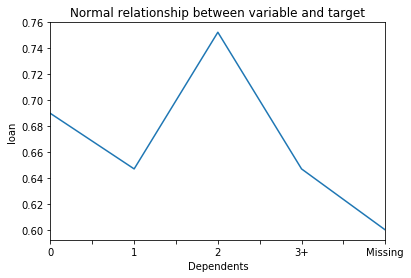

In [461]:
# let's inspect the newly created monotonic relationship with the target

#first we plot the original variable for comparison, there is no monotonic relationship

fig = plt.figure()
fig = data.groupby(['Dependents'])['Loan_Status'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('loan')

Text(0, 0.5, 'loan')

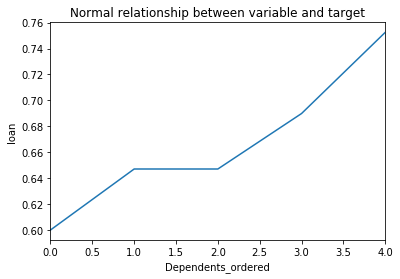

In [462]:
fig = plt.figure()
fig = data.groupby(['Dependents_ordered'])['Loan_Status'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('loan')

There is now a monotonic relationship between the variable Dependents and probability of giving loan. The higher the Cabin number, the more likely the person was to survive.

### Note

Monotonic does not mean strictly linear. Monotonic means that it increases constantly, or it decreases constantly.

Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand, as we explained in previous sections.

## Mean encoding

In [463]:
data = pd.read_csv('train.csv', usecols=['Dependents','Loan_Status'])
data.head()

,Dependents,Loan_Status
0,0,Y
1,1,N
2,0,Y
3,0,Y
4,0,Y


In [464]:
# let's first fill NA values with an additional label

data.Dependents.fillna('Missing', inplace=True)
data.tail()

,Dependents,Loan_Status
609,0,Y
610,3+,Y
611,1,Y
612,2,Y
613,0,N


In [465]:
for i in range(0,len(data['Loan_Status'])):
    if data['Loan_Status'][i]=='Y':
        data['Loan_Status'][i]=1
    else:
        data['Loan_Status'][i]=0

In [466]:
data['Loan_Status']=data['Loan_Status'].astype('int64')

In [467]:
# now we order the labels according to the mean target value

data.groupby(['Dependents'])['Loan_Status'].mean().sort_values()

Dependents
Missing    0.600000
1          0.647059
3+         0.647059
0          0.689855
2          0.752475
Name: Loan_Status, dtype: float64

In [468]:
# and now let's do the same but capturing the result in a dictionary

ordered_labels = data.groupby(['Dependents'])['Loan_Status'].mean().to_dict()
ordered_labels

{'0': 0.6898550724637681,
 '1': 0.6470588235294118,
 '2': 0.7524752475247525,
 '3+': 0.6470588235294118,
 'Missing': 0.6}

In [469]:
# replace the labels with the 'risk' (target frequency)
# note that we calculated the frequencies based on the training set only

data['Dependents_ordered'] = data.Dependents.map(ordered_labels)

In [470]:
# check the results

data.head()

,Dependents,Loan_Status,Dependents_ordered
0,0,1,0.689855
1,1,0,0.647059
2,0,1,0.689855
3,0,1,0.689855
4,0,1,0.689855


Text(0, 0.5, 'loan')

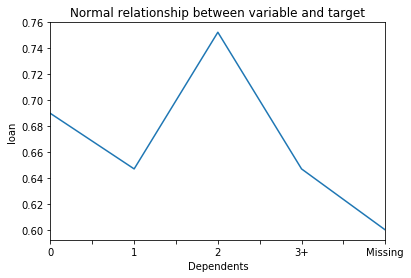

In [471]:
# let's inspect the newly created monotonic relationship with the target

#first we plot the original variable for comparison, there is no monotonic relationship

fig = plt.figure()
fig = data.groupby(['Dependents'])['Loan_Status'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('loan')

Text(0, 0.5, 'loan')

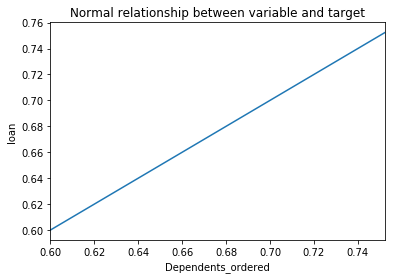

In [472]:
fig = plt.figure()
fig = data.groupby(['Dependents_ordered'])['Loan_Status'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('loan')

Here the relationship lies perfectly on a diagonal line, because this is how we replaced the categories. 

## Weight  of evidence

Weight of Evidence (WoE) was developed primarily for the credit and financial industries to help build more predictive models to evaluate the risk of loan default. That is, to predict how likely the money lent to a person or institution is to be lost. Thus, Weight of Evidence is a measure of the "strength” of a grouping technique to separate good and bad risk (default). 

It is computed from the basic odds ratio: ln( (Proportion of Good Credit Outcomes) / (Proportion of Bad Credit Outcomes))

WoE will be 0 if the P(Goods) / P(Bads) = 1. That is, if the outcome is random for that group. If P(Bads) > P(Goods) the odds ratio will be < 1 and the WoE will be < 0; if, on the other hand, P(Goods) > P(Bads) in a group, then WoE > 0.

WoE is well suited for Logistic Regression, because the Logit transformation is simply the log of the odds, i.e., ln(P(Goods)/P(Bads)). Therefore, by using WoE-coded predictors in logistic regression, the predictors are all prepared and coded to the same scale, and the parameters in the linear logistic regression equation can be directly compared.

The WoE transformation has three advantages:

- It establishes a monotonic relationship to the dependent variable.
- It orders the categories on a "logistic" scale which is natural for logistic regression
- The transformed variables, can then be compared because they are on the same scale. Therefore, it is possible to determine which one is more predictive.

The WoE also has three drawbacks:

- May incur in loss of information (variation) due to binning to few categories (we will discuss this further in the discretisation section)
- It does not take into account correlation between independent variables
- Prone to cause over-fitting


For more details follow this link:

http://documentation.statsoft.com/StatisticaHelp.aspx?path=WeightofEvidence/WeightofEvidenceWoEIntroductoryOverview

Let's see how to implement WoE in python

In [473]:
data = pd.read_csv('train.csv', usecols=['Dependents','Loan_Status'])
data.head()

,Dependents,Loan_Status
0,0,Y
1,1,N
2,0,Y
3,0,Y
4,0,Y


In [474]:
# let's first fill NA values with an additional label

data.Dependents.fillna('Missing', inplace=True)
data.tail()

,Dependents,Loan_Status
609,0,Y
610,3+,Y
611,1,Y
612,2,Y
613,0,N


In [475]:
# check the labels
data.Dependents.unique()

array(['0', '1', '2', '3+', 'Missing'], dtype=object)

### Important

The calculation of the WoE to replace the labels should be done considering the ONLY the training set, and then expanded it to the test set

In [476]:
for i in range(0,len(data['Loan_Status'])):
    if data['Loan_Status'][i]=='Y':
        data['Loan_Status'][i]=1
    else:
        data['Loan_Status'][i]=0

In [477]:
data['Loan_Status']=data['Loan_Status'].astype('int64')

In [478]:
# now we order the labels according to the mean target value

data.groupby(['Dependents'])['Loan_Status'].mean().sort_values()

Dependents
Missing    0.600000
1          0.647059
3+         0.647059
0          0.689855
2          0.752475
Name: Loan_Status, dtype: float64

In [479]:
# let's make a dataframe with the above calculation

prob_df = data.groupby(['Dependents'])['Loan_Status'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df

,Loan_Status
Dependents,
0,0.689855
1,0.647059
2,0.752475
3+,0.647059
Missing,0.600000


In [482]:
# and now the probability of target = 0 
# and we add it to the dataframe

prob_df = data.groupby(['Dependents'])['Loan_Status'].mean()
prob_df = pd.DataFrame(prob_df)
prob_df['NoLoan'] = 1-prob_df.Loan_Status
prob_df

,Loan_Status,NoLoan
Dependents,,
0,0.689855,0.310145
1,0.647059,0.352941
2,0.752475,0.247525
3+,0.647059,0.352941
Missing,0.600000,0.400000


In [483]:
# since the log of zero is not defined, let's set this number to something small and non-zero

prob_df.loc[prob_df.Loan_Status == 0, 'Loan_Status'] = 0.00001
prob_df

,Loan_Status,NoLoan
Dependents,,
0,0.689855,0.310145
1,0.647059,0.352941
2,0.752475,0.247525
3+,0.647059,0.352941
Missing,0.600000,0.400000


In [484]:
# now we calculate the WoE

prob_df['WoE'] = np.log(prob_df.Loan_Status/prob_df.NoLoan)
prob_df

,Loan_Status,NoLoan,WoE
Dependents,,,
0,0.689855,0.310145,0.799442
1,0.647059,0.352941,0.606136
2,0.752475,0.247525,1.111858
3+,0.647059,0.352941,0.606136
Missing,0.600000,0.400000,0.405465


In [485]:
# and we create a dictionary to re-map the variable

prob_df['WoE'].to_dict()

{'0': 0.7994418392095684,
 '1': 0.6061358035703157,
 '2': 1.1118575154181303,
 '3+': 0.6061358035703157,
 'Missing': 0.4054651081081642}

In [486]:
# and we make a dictionary to map the orignal variable to the WoE
# same as above but we capture the dictionary in a variable

ordered_labels = prob_df['WoE'].to_dict()

In [487]:
# replace the labels with the WoE

data['Dependents_ordered'] = data.Dependents.map(ordered_labels)

In [488]:
# check the results

data.head()

,Dependents,Loan_Status,Dependents_ordered
0,0,1,0.799442
1,1,0,0.606136
2,0,1,0.799442
3,0,1,0.799442
4,0,1,0.799442


Text(0, 0.5, 'loan')

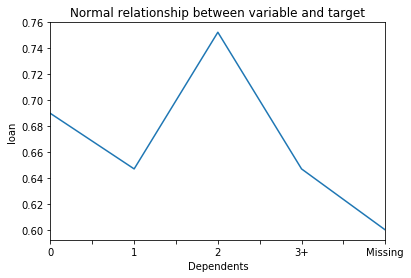

In [489]:
# let's inspect the newly created monotonic relationship with the target

#first we plot the original variable for comparison, there is no monotonic relationship

fig = plt.figure()
fig = data.groupby(['Dependents'])['Loan_Status'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('loan')

Text(0, 0.5, 'loan')

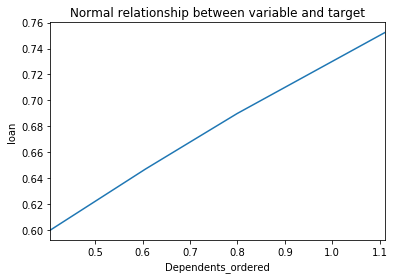

In [490]:
fig = plt.figure()
fig = data.groupby(['Dependents_ordered'])['Loan_Status'].mean().plot()
fig.set_title('Normal relationship between variable and target')
fig.set_ylabel('loan')